In [1]:
import pandas as pd
import os
import re
import sys
import numpy as np
from merf import MERF
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
sns.set_context("poster")
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from merf.merf import MERF
from sklearn.model_selection import train_test_split, KFold
from merf.viz import plot_merf_training_stats

current_dir = os.getcwd() # Get the current working directory
parent_dir = os.path.abspath(os.path.join(current_dir, '../'))
sys.path.append(parent_dir)
from em_utils import * # import the utils

In [2]:
# Create output directory if it doesn't exist
output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
df_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
os.makedirs(df_dir, exist_ok=True)

print("---------- Read data ----------")
input_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/data/april_processing/"
long = read_data(input_dir,"long_april29.csv")
delta = read_data(input_dir, "all_delta_april29.csv")
print(long.columns.to_list)
print(delta.columns.to_list)

---------- Read data ----------
<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'record_id', 'time', 'subject_id', 'randomized_group',
       'consent', 'cohort_number', 'sex', 'race', 'completer',
       ...
       'Isovalerate..3.Methylbutanoate', 'phenylacetate', 'Succinate',
       'Isobutyrate..2.Methylpropanoate', 'Water', 'Hydrogen', 'Dephospho.CoA',
       'indole.3.acetate', 'Malonate', 'aldehydo.D.xylose'],
      dtype='object', length=402)>
<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'subject_id', 'record_id', 'time', 'randomized_group',
       'consent', 'cohort_number', 'sex', 'race', 'completer',
       ...
       'nitrate.reduction.VI..assimilatory.', 'TCA.cycle.VIII..helicobacter.',
       'L.rhamnose.degradation.I', 'formaldehyde.oxidation.I',
       'adenosine.nucleotides.degradation.II',
       'sulfate.reduction.I..assimilatory.',
       'teichoic.acid..poly.glycerol..biosynthesis',
       'superpathway.of.thiamin.diphosphate.biosynthesis.I

In [3]:
print(long.columns.to_list()) 
print(delta.columns.to_list()) 

['Unnamed: 0', 'record_id', 'time', 'subject_id', 'randomized_group', 'consent', 'cohort_number', 'sex', 'race', 'completer', 'outcome_BMI_fnl', 'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'Peptide_YY', 'Ghrelin', 'Leptin', 'Hemoglobin_A1C', 'bmi_prs', 'non_HDL_C', 'Remnant_C', 'VLDL_C', 'Clinical_LDL_C', 'VLDL_TG', 'LDL_TG', 'HDL_TG', 'Total_PL', 'VLDL_PL', 'Total_CE', 'VLDL_CE', 'HDL_CE', 'Total_FC', 'LDL_FC', 'HDL_FC', 'Total_L', 'VLDL_L', 'HDL_L', 'VLDL_P', 'LDL_P', 'HDL_P', 'VLDL_size', 'LDL_size', 'HDL_size', 'TG_by_PG', 'Cholines', 'Phosphatidylc', 'Sphingomyelins', 'ApoB_by_ApoA1', 'Total_FA', 'Unsaturation', 'Omega_3', 'Omega_6', 'MUFA', 'SFA', 'LA', 'DHA', 'Omega_3_pct', 'Omega_6_pct', 'PUFA_pct', 'MUFA_pct', 'SFA_pct', 'LA_pct', 'DHA_pct', 'PUFA_by_MUFA', 'Omega_6_by_Omega_3', 'Ala', 'Gln', 'Gly', 'His', 'Total_BCAA', 'Ile', 'Leu', 'Val', 'Phe', 'Tyr', 'Glucose.y', 'Lactate', 'Pyruvate', 'Citrate', 'Glycero

In [4]:
columns_to_drop = ['Peptide_YY', 'Ghrelin', 'Leptin', 'completer', 'consent', 'Hemoglobin_A1C', 'record_id']
long = long.drop([col for col in columns_to_drop if col in long.columns], axis=1)
print(long.columns.to_list)
#Make time numeric 
time_mapping = {
    "BL": 0,
    "6m": 6,
    "12m": 12
}
long['time'] = long['time'].replace(time_mapping)
print(long['time'])

<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'time', 'subject_id', 'randomized_group', 'cohort_number',
       'sex', 'race', 'outcome_BMI_fnl', 'age', 'Glucose.x',
       ...
       'Isovalerate..3.Methylbutanoate', 'phenylacetate', 'Succinate',
       'Isobutyrate..2.Methylpropanoate', 'Water', 'Hydrogen', 'Dephospho.CoA',
       'indole.3.acetate', 'Malonate', 'aldehydo.D.xylose'],
      dtype='object', length=395)>
0       0
1       0
2       0
3       0
4       0
       ..
383    12
384    12
385    12
386    12
387    12
Name: time, Length: 388, dtype: int64


'time', 'subject_id.x', 'randomized_group', 'cohort_number', 'sex', 'race', 'subject_id.y', 'outcome_BMI_fnl', 'age', 'Glucose', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'bmi_prs', 'g__Coprenecus', 

In [5]:
BMI_VAR, ID_VAR, TIME_VAR, DATA = 'outcome_BMI_fnl', 'subject_id', 'time', long
# Specify columns for long
#basic = [BMI_VAR, ID_VAR, TIME_VAR, 'age','sex']
#meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'cohort_number', 'sex', 'race', 'age', 'Glucose', 'HDL_Total_Direct_lipid', 'HOMA_IR', 'Insulin_endo', 'LDL_Calculated', 'Triglyceride_lipid']
#only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
#only_taxa = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col.startswith("g__")]
#proton_column = DATA.columns.get_loc("proton")
#carbon_dioxide_column = DATA.columns.get_loc("Carbon.dioxide")
#only_micom = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col in DATA.columns[proton_column:carbon_dioxide_column+1]]
# Create a set of all columns to EXCLUDE for pathway
#exclude_columns = set(meta_keep + only_grs + only_taxa + only_micom)
#only_pathway = [BMI_VAR, ID_VAR, TIME_VAR] + [col for col in DATA.columns if col not in exclude_columns]

# Define the column names based on your lists
basic = [BMI_VAR, ID_VAR, TIME_VAR, 'sex', 'age', 'randomized_group']
meta_keep = [BMI_VAR, ID_VAR, TIME_VAR, 'randomized_group', 'sex', 'race', 
             'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid']
only_grs = [BMI_VAR, ID_VAR, TIME_VAR, 'bmi_prs']
only_taxa = [BMI_VAR, ID_VAR, TIME_VAR,] + [col for col in DATA.columns if col.startswith("g__")]

micom_start = DATA.columns.get_loc("Diacetyl")
micom_end = DATA.columns.get_loc("aldehydo.D.xylose")
only_micom = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[micom_start:micom_end + 1])

path_start = DATA.columns.get_loc("arginine..ornithine.and.proline.interconversion")
path_end = DATA.columns.get_loc("UDP.N.acetyl.D.glucosamine.biosynthesis.I")
only_pathway = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[path_start:path_end + 1])

metabo_start = DATA.columns.get_loc("non_HDL_C")
metabo_end = DATA.columns.get_loc("IDL_TG_pct")
only_metabo = [BMI_VAR, ID_VAR, TIME_VAR,] + list(DATA.columns[metabo_start:metabo_end + 1])

# Define the list of columns to include
all_col = [BMI_VAR, ID_VAR, TIME_VAR,] + ['randomized_group', 'sex', 'race',
    'age','Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid'] + \
    list(DATA.columns[DATA.columns.str.startswith("g__")]) + \
    list(DATA.columns[micom_start:micom_end + 1]) + \
    list(DATA.columns[path_start:path_end + 1]) + \
    list(DATA.columns[metabo_start:metabo_end + 1])

Set up MERF 

In [6]:
# test sample names
#test_names = ["ABR-079", "AGA-071", "AHE-055", "ALI-121", "ALO-163", "AMA-031", "ASO-013", "AWI-167", "BMO-164", "CWA-183", "DSC-024", "EBE-130", "EHI-177", "EJO-092", "GFU-188", "HGI-010", "JCA-109", "JGO-100",
#    "KBU-085", "KCE-034", "KHE-170", "LDO-148", "LST-186", "LZD-142", "MAR-119", "MCA-088", "MJA-153", "MWE-112", "NPO-149", "RAE-114", "SBO-020", "SEG-080", "SKA-195", "SLO-178", "SSH-028", "TDU-086","TFA-016", "VCA-041"]
test_names = ["ASO-013", "NTA-021", "KGI-029", "KPA-042", "AWA-052", "AHE-055", "COW-066", "NBI-069", "CEL-073", "CAL-074", "ABR-079", "SEG-080", "NKA-090", "NEL-094", "LJA-101", "ADA-105", "MLU-106", "MDI-107", "JER-110", "TRO-113", "MFB-118", "ALI-121", "KWA-122", "RAF-125", "EBE-130", "CGA-134", "LZD-142", "NPO-149", "HDE-154", "AMC-155", "SAB-160", "QNG-166", "NCO-171", "BSA-174", "EHI-177", "LST-186", "MBA-187", "BAN-193"]
#
#train_names = ["AAL-144", "ACO-053", "ADA-105", "AKE-009", "AKI-011", "AKO-139", "AMC-155", "AME-128", "AME-157", "ATA-129", "AWA-052", "AWA-083", "BAN-193", "BHO-014", "BIN-201", "BKN-104", "BMI-156", "BSA-174", "CAM-057", "CCO-189",
#    "CED-026", "CEL-073", "CGA-134", "CIS-077", "CKR-078", "CLE-049", "COW-066", "CRO-108", "CWA-161", "EBE-051", "EKA-135", "EKR-045", "ELA-159", "EPO-182", "EVO-184", "FWI-098", "GHA-035", "HDE-154", "IBE-120", "JDI-140", "JER-110", "JFU-027", "JJO-093", "JKN-127", "JPO-022", "JUG-116", "JUT-032", "JVE-126", "KAN-138", "KBR-162", "KEL-185", "KEL-199", "KGI-029", "KHU-196", "KPA-042", "KRI-072", "KVA-038", "KWA-122", "KWA-141", "LBL-047", "LBU-015", "LEL-147", "LFI-003", "LJA-101", "LMC-111", "LPF-198", "LVA-017", "MBA-187", "MCW-065", "MDI-107", "MES-068", "MFB-118", "MGA-076", "MHO-117", "MKE-192", "MMA-036", "MRT-179", "MSH-091", "MST-039", "MWE-143",
#    "MWO-133", "MWY-152", "NAR-099", "NBI-048", "NBI-069", "NCO-171", "NDI-067", "NEL-094", "NKA-090", "NMO-151", "NTA-021", "PBE-123", "QNG-166", "RAF-125", "RAM-050", "RHP-023", "RLA-132", "ROL-006", "SAB-160", "SCA-043", "SCR-061", "SDA-150", "SGA-062", "SKA-087", "SRO-194", "TBU-115", "TFA-172", "TRO-113", "TSH-146", "TSL-056", "WPE-005", "YOR-103", "YSU-097", "ZVU-096"]
train_names = ["SDA-150", "LBU-015", "CIS-077", "ATA-129", "KHU-196", "MWY-152", "AGA-071", "AME-157", "CWA-183", "RHP-023", "MST-025", "SSH-028", "JUG-116", "EJO-092", "VCA-041", "NMO-151", "BHO-014", "KBU-085", "SBO-020", "MWO-133", "KRI-072", "AAL-144", "ALO-163", "AKI-011", "MHO-117", "TSH-146", "RAE-114", "FWI-098", "MAR-119", "JGO-100", "CAM-057", "YOR-103", "HGI-010", "KAN-138", "SGA-062", "CKR-078", "MWE-112", "ROL-006", "MMA-036", "DSC-024", "LDO-148", "MCA-088", "CPU-075", "AKO-139", "LFI-003", "KWA-141", "GFU-188", "BMO-164", "JPO-022", "EVO-184", "LPF-198", "TBU-115", "SRO-194", "KEL-199", "JFU-027", "SKA-195", "IBE-120", "TSL-056", "NDI-067", "AWA-083", "CWA-161", "TDU-086", "JCA-109", "CBO-004", "NAR-099", "MES-068", "AMA-031", "SLO-178", "SCA-043", "AWI-167",  "KBR-162", "TFA-172", "BIN-201", "NBI-048", "KHE-170", "CSH-012", "BMI-156", "MWE-143", "EKA-135", "WPE-005", "AKE-009", "YSU-097", "MCW-065", "EBE-051", "ZVU-096", "JJO-093", "KVA-038", "ACO-053", "RLA-132", "MBA-176", "CED-026", "JDI-140", "CCO-189", "EKR-045", "MJA-153", "CLE-049", "LMC-111", "SKA-087", "JUT-032", "MKE-192", "JVE-126", "KCE-034", "KEL-185", "MRT-179", "JKN-127", "LEL-147", "BKN-104", "AME-128", "MSH-091", "MGA-076", "LVA-017", "EPO-182"]

print("Length of test names:", len(test_names))
print("Length of train names:", len(train_names))

Length of test names: 38
Length of train names: 112


In [7]:
column_sets = {
    "basic": basic,
    "meta_keep": meta_keep,
    "only_grs": only_grs, 
    "only_taxa": only_taxa,
    "only_micom": only_micom,
    "only_pathway": only_pathway,
    "only_metabo" : only_metabo,
    "only_all" : all_col
}

# Initialize a list to store summary data
summary_data = []

# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = long[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    
    # Calculate summary statistics
    summary = DATA.groupby('time').agg(
    unique_id_count=(ID_VAR, 'nunique'),  # Count unique ID_VAR
    feature_count=('time', lambda x: DATA.shape[1] - 2)  # Count total features excluding 'time' and 'ID_VAR'
    ).reset_index()
    
    # Print the summary table
    print("\nSummary Table for", key)
    print(summary.to_string(index=False))  # Print without the index
    
    # Append summary to the summary_data list
    summary_data.append((key, summary))

Subset for basic created with shape: (388, 6)

Summary Table for basic
 time  unique_id_count  feature_count
    0              150              4
    6              124              4
   12              114              4
Subset for meta_keep created with shape: (388, 13)

Summary Table for meta_keep
 time  unique_id_count  feature_count
    0              150             11
    6              124             11
   12              114             11
Subset for only_grs created with shape: (388, 4)

Summary Table for only_grs
 time  unique_id_count  feature_count
    0              150              2
    6              124              2
   12              114              2
Subset for only_taxa created with shape: (388, 124)

Summary Table for only_taxa
 time  unique_id_count  feature_count
    0              150            122
    6              124            122
   12              114            122
Subset for only_micom created with shape: (388, 56)

Summary Table for only_micom
 

Subset for only_all created with shape: (388, 392)
---------- Select predictors for training set only_all ----------
Length of X: 300, Length of clusters_train: 300, Length of Y: 300
Final columns after drop: ['time', 'randomized_group', 'sex', 'race', 'age', 'Glucose.x', 'HOMA_IR', 'Insulin_endo', 'HDL_Total_Direct_lipid', 'LDL_Calculated', 'Triglyceride_lipid', 'g__Coprenecus', 'g__Butyricimonas', 'g__Odoribacter_865974', 'g__Alistipes_A_871404', 'g__Paramuribaculum', 'g__Alistipes_A_871400', 'g__Phocaeicola_A_858004', 'g__Bacteroides_H', 'g__Prevotella', 'g__Methanobrevibacter_A', 'g__DTU012', 'g__Escherichia_710834', 'g__Parasutterella', 'g__Sutterella', 'g__Haemophilus_D_735815', 'g__Akkermansia', 'g__Adlercreutzia_404257', 'g__Eggerthella', 'g__CAG-1427', 'g__Collinsella', 'g__Holdemania', 'g__Erysipelatoclostridium', 'g__Faecalibacillus', 'g__Holdemanella', 'g__Clostridium_AQ', 'g__Longicatena', 'g__Bifidobacterium_388775', 'g__Acidaminococcus', 'g__Phascolarctobacterium_A', 'g_

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 367.6770252471735 at iteration 1.
INFO     [merf.py:307] Training GLL is 407.28715083427016 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 423.5154624424502 at iteration 1.


Combination, ptev: 0.5879, prev: 0.4121, OOB Score: 16.2000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 508.2454279935168 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Combination, ptev: 0.6226, prev: 0.3774, OOB Score: -151.7000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 418.97782375444086 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 477.4397666994785 at iteration 2.


Combination, ptev: 0.6243, prev: 0.3757, OOB Score: -28.7000
Combination: (10, None, 0.05, 2, 5)

Progress: 3.70% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 439.4534645173307 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 523.102196532725 at iteration 2.


Combination, ptev: 0.5965, prev: 0.4035, OOB Score: -150.8000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 475.17043191114766 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 541.8825846769817 at iteration 2.


Combination, ptev: 0.5759, prev: 0.4241, OOB Score: -53.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 560.9289706845295 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 563.203846439247 at iteration 2.


Combination, ptev: 0.6025, prev: 0.3975, OOB Score: -8.2000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 496.9069363331874 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 589.6748567438341 at iteration 2.


Combination, ptev: 0.6253, prev: 0.3747, OOB Score: -19.5000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 533.5003671837685 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 552.6294235190783 at iteration 2.


Combination, ptev: 0.6269, prev: 0.3731, OOB Score: -64.4000
Combination: (10, None, 0.05, 2, 10)

Progress: 5.56% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 596.0698262746481 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 615.912183135621 at iteration 2.


Combination, ptev: 0.6449, prev: 0.3551, OOB Score: -0.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 549.4645618340168 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 601.9621067640848 at iteration 2.


Combination, ptev: 0.6305, prev: 0.3695, OOB Score: -111.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 584.5747613565791 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 625.2374181141589 at iteration 2.


Combination, ptev: 0.6027, prev: 0.3973, OOB Score: -97.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 578.7015045577463 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 594.9260945309834 at iteration 2.


Combination, ptev: 0.6194, prev: 0.3806, OOB Score: -65.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 592.002572129916 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 594.4153551684678 at iteration 2.


Combination, ptev: 0.6267, prev: 0.3733, OOB Score: -115.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 573.8045030728082 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 600.2658237987891 at iteration 2.


Combination, ptev: 0.6400, prev: 0.3600, OOB Score: -21.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 564.0232609387805 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 611.9168917636249 at iteration 2.


Combination, ptev: 0.6516, prev: 0.3484, OOB Score: -5.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 536.8603516164883 at iteration 1.
INFO     [merf.py:307] Training GLL is 587.5046814378668 at iteration 2.


Combination, ptev: 0.6611, prev: 0.3389, OOB Score: 16.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 603.805723546049 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 623.2876808347581 at iteration 2.


Combination, ptev: 0.6631, prev: 0.3369, OOB Score: -32.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 596.3224667871141 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 607.9746613475298 at iteration 2.
INFO     [merf.py:307] Training GLL is 387.64638162453537 at iteration 1.


Combination, ptev: 0.6563, prev: 0.3437, OOB Score: -88.3000
Combination: (10, None, 0.05, 10, 3)

Progress: 7.41% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 431.65459605691075 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 413.87005499301847 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.7057, prev: 0.2943, OOB Score: -151.0000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 506.32515727918405 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 500.14419094108075 at iteration 3.
INFO     [merf.py:307] Training GLL is 498.0623108481243 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/

Combination, ptev: 0.7663, prev: 0.2337, OOB Score: -257.3000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 503.2431507865828 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 494.39141688639126 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.7854, prev: 0.2146, OOB Score: -57.5000
Combination: (10, None, 0.05, 10, 5)

Progress: 9.26% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 455.5789719658696 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 476.5443953726312 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6876, prev: 0.3124, OOB Score: -427.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 505.48313755634746 at iteration 1.
INFO     [merf.py:307] Training GLL is 546.7172916035075 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 522.8102206549263 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 505.34155701920184 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-p

Combination, ptev: 0.6878, prev: 0.3122, OOB Score: -194.4000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 525.6917169658099 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 512.3062343727806 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7616, prev: 0.2384, OOB Score: -53.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 557.7242360940239 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 588.7585926221359 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 540.1959872904845 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.7808, prev: 0.2192, OOB Score: -115.6000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 493.9207357718583 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 543.5859940502141 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8002, prev: 0.1998, OOB Score: -570.4000
Combination: (10, None, 0.05, 10, 10)

Progress: 11.11% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 515.9926773791275 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 557.3084420638716 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6333, prev: 0.3667, OOB Score: -26.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 543.5898434001632 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 579.8684521864151 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6361, prev: 0.3639, OOB Score: 60.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 590.6814112428078 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 624.6084110684212 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6984, prev: 0.3016, OOB Score: -131.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 511.0692034306504 at iteration 1.
INFO     [merf.py:307] Training GLL is 582.8465206437475 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 600.814778997956 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7191, prev: 0.2809, OOB Score: -356.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 602.218216483599 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 605.8395495785561 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7519, prev: 0.2481, OOB Score: -268.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 574.4221938652261 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 591.1228007029341 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7770, prev: 0.2230, OOB Score: -277.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 587.8988754488696 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 607.2302249557423 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7997, prev: 0.2003, OOB Score: -333.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 552.7056004064342 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 601.6343723655291 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8039, prev: 0.1961, OOB Score: -193.2000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 583.0070883982677 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 656.1252070373296 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8154, prev: 0.1846, OOB Score: -323.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 551.5020365550789 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 608.8025041209988 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8164, prev: 0.1836, OOB Score: -28.1000
Combination: (10, None, 0.1, 2, 3)

Progress: 12.96% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 485.88857819561673 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 539.5991799069353 at iteration 1.


Combination, ptev: 0.5782, prev: 0.4218, OOB Score: -81.3000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 595.658890728976 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 518.8927217471505 at iteration 1.


Combination, ptev: 0.6482, prev: 0.3518, OOB Score: -11.4000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 596.575075539255 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 577.2029452595442 at iteration 1.


Combination, ptev: 0.6600, prev: 0.3400, OOB Score: -97.2000
Combination: (10, None, 0.1, 2, 5)

Progress: 14.81% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 551.139810766503 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 591.9275845613068 at iteration 1.


Combination, ptev: 0.6085, prev: 0.3915, OOB Score: -19.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 628.54332728601 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 601.651953456387 at iteration 1.


Combination, ptev: 0.6147, prev: 0.3853, OOB Score: -95.4000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 632.6211699461297 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 598.6905487631607 at iteration 1.


Combination, ptev: 0.6621, prev: 0.3379, OOB Score: -17.8000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 649.1692412665734 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 632.5167431400963 at iteration 1.


Combination, ptev: 0.6743, prev: 0.3257, OOB Score: -41.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 653.9465048510307 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 697.790716116003 at iteration 1.


Combination, ptev: 0.6853, prev: 0.3147, OOB Score: -91.7000
Combination: (10, None, 0.1, 2, 10)

Progress: 16.67% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 690.5849563576915 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 652.943023170833 at iteration 1.


Combination, ptev: 0.6379, prev: 0.3621, OOB Score: -101.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 660.3080763961786 at iteration 2.


Combination, ptev: 0.6380, prev: 0.3620, OOB Score: -14.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 691.1067588615078 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 683.8418340539084 at iteration 2.


Combination, ptev: 0.6673, prev: 0.3327, OOB Score: -155.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 661.2023104258235 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 668.2606514809512 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6731, prev: 0.3269, OOB Score: -94.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 694.20111507369 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 733.5533351690028 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 679.9814651207813 at iteration 1.


Combination, ptev: 0.6939, prev: 0.3061, OOB Score: -134.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 696.6338109963017 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


Combination, ptev: 0.7129, prev: 0.2871, OOB Score: -25.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 690.7492012203743 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 711.6471341111272 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 729.495304422737 at iteration 1.


Combination, ptev: 0.7346, prev: 0.2654, OOB Score: -19.9000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 730.8591368693659 at iteration 2.


Combination, ptev: 0.7283, prev: 0.2717, OOB Score: -204.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 693.5536232139243 at iteration 1.
INFO     [merf.py:307] Training GLL is 717.9467564717714 at iteration 2.


Combination, ptev: 0.7356, prev: 0.2644, OOB Score: 28.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 634.7324992347048 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 697.7834439876897 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 465.6956106917693 at iteration 1.


Combination, ptev: 0.7293, prev: 0.2707, OOB Score: -100.1000
Combination: (10, None, 0.1, 10, 3)

Progress: 18.52% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 481.83704618030697 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 446.33846846310684 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs d

Combination, ptev: 0.7090, prev: 0.2910, OOB Score: 65.3000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 598.8455289359005 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 599.2227279967769 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7605, prev: 0.2395, OOB Score: 66.2000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 606.0750099312193 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 609.6075246147653 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7851, prev: 0.2149, OOB Score: -60.7000
Combination: (10, None, 0.1, 10, 5)

Progress: 20.37% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 597.0952556694772 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 542.8264719017144 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6691, prev: 0.3309, OOB Score: -922.2000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 590.0529012031988 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 659.5641717278271 at iteration 2.
INFO     [merf.py:307] Training GLL is 614.8207211044801 at iteration 3.
INFO     [merf.py:307] Training GLL is 612.965297869416 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: 0.7115, prev: 0.2885, OOB Score: -363.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 669.982933422964 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 654.0274111976826 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7773, prev: 0.2227, OOB Score: 55.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 658.2917624218038 at iteration 2.
INFO     [merf.py:307] Training GLL is 649.3140155103378 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 629.2409548183351 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.8028, prev: 0.1972, OOB Score: -231.0000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 684.6010350590806 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 656.7108255502194 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8186, prev: 0.1814, OOB Score: -336.0000
Combination: (10, None, 0.1, 10, 10)

Progress: 22.22% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 641.2793738330397 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 706.814091681386 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 672.8103546321275 at iteration 3.
INFO     [merf.py:307] Training GLL is 647.2951718603139 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-pred

Combination, ptev: 0.6565, prev: 0.3435, OOB Score: -17.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 674.0588908350026 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 696.9545333064167 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 648.9586830188334 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.6606, prev: 0.3394, OOB Score: 65.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 712.6462659996237 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 696.2842286301764 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7179, prev: 0.2821, OOB Score: -380.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 674.744489161407 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 711.796868810571 at iteration 3.
INFO     [merf.py:307] Training GLL is 692.5590856387279 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

Combination, ptev: 0.7252, prev: 0.2748, OOB Score: -478.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 662.5759440710403 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 719.6647973068956 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7598, prev: 0.2402, OOB Score: -129.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 672.2822211774949 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 688.3379605812684 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7856, prev: 0.2144, OOB Score: -135.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 711.8220543610732 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 671.7708569814756 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8034, prev: 0.1966, OOB Score: -253.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 712.4683000437578 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 710.7171758705398 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8117, prev: 0.1883, OOB Score: -526.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 678.2788861284761 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 721.3992976203848 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8221, prev: 0.1779, OOB Score: -12.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 698.7253232632443 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 660.4030893191881 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8244, prev: 0.1756, OOB Score: 58.8000
Combination: (10, None, 0.15, 2, 3)

Progress: 24.07% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 510.6600074320327 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 588.0425076410531 at iteration 1.


Combination, ptev: 0.6326, prev: 0.3674, OOB Score: -43.2000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 617.1015933365294 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 595.2596815788743 at iteration 1.


Combination, ptev: 0.6907, prev: 0.3093, OOB Score: -85.6000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 654.6571461085715 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 627.3479893869336 at iteration 1.


Combination, ptev: 0.6956, prev: 0.3044, OOB Score: 19.0000
Combination: (10, None, 0.15, 2, 5)

Progress: 25.93% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 611.2326167508502 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 650.7466769252668 at iteration 1.


Combination, ptev: 0.6334, prev: 0.3666, OOB Score: -60.7000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 679.2921680522556 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 665.3431636553945 at iteration 1.


Combination, ptev: 0.6576, prev: 0.3424, OOB Score: -133.3000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 706.2960653855712 at iteration 2.


Combination, ptev: 0.6978, prev: 0.3022, OOB Score: -139.1000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 675.693059198113 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 705.8482300971341 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7255, prev: 0.2745, OOB Score: -102.1000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 705.1017988744522 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 719.2721107573636 at iteration 1.


Combination, ptev: 0.7294, prev: 0.2706, OOB Score: -96.0000
Combination: (10, None, 0.15, 2, 10)

Progress: 27.78% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 697.3337567603639 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 716.1750504304048 at iteration 1.


Combination, ptev: 0.6933, prev: 0.3067, OOB Score: -127.3000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 749.8352779041154 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 768.7348202587071 at iteration 1.


Combination, ptev: 0.6720, prev: 0.3280, OOB Score: -43.0000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 789.4967323615735 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 721.2738129730193 at iteration 1.


Combination, ptev: 0.7083, prev: 0.2917, OOB Score: -140.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 754.5112027648784 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 791.5087143123459 at iteration 1.


Combination, ptev: 0.6996, prev: 0.3004, OOB Score: -52.6000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 780.195473035693 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 724.301912713257 at iteration 1.


Combination, ptev: 0.7252, prev: 0.2748, OOB Score: -24.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 760.8168302123145 at iteration 2.
INFO     [merf.py:307] Training GLL is 766.573404923547 at iteration 1.


Combination, ptev: 0.7439, prev: 0.2561, OOB Score: -134.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 774.8731879039624 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 744.5082637620492 at iteration 1.


Combination, ptev: 0.7580, prev: 0.2420, OOB Score: -49.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 748.3279515660267 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 754.3954781437923 at iteration 1.


Combination, ptev: 0.7602, prev: 0.2398, OOB Score: -47.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 779.9467860898916 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 759.4342118726538 at iteration 1.


Combination, ptev: 0.7680, prev: 0.2320, OOB Score: -16.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 739.9014467316114 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 496.862156775593 at iteration 1.


Combination, ptev: 0.7615, prev: 0.2385, OOB Score: -153.9000
Combination: (10, None, 0.15, 10, 3)

Progress: 29.63% completed

Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 500.6142915833097 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 458.47781291374224 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do

Combination, ptev: 0.6920, prev: 0.3080, OOB Score: -653.4000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 664.859056949638 at iteration 2.
INFO     [merf.py:307] Training GLL is 675.9742875942401 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 661.6099940051483 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7591, prev: 0.2409, OOB Score: -65.3000
Length of clusters_train: 200
Length of clusters_test: 100


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 661.8746209781357 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 659.909896407428 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7893, prev: 0.2107, OOB Score: 64.7000
Combination: (10, None, 0.15, 10, 5)

Progress: 31.48% completed

Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 616.2512752806174 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 593.9418052058963 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6566, prev: 0.3434, OOB Score: -83.6000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 680.5282998061815 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 660.2798426225918 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6771, prev: 0.3229, OOB Score: -156.8000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 723.0530257722733 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 704.8984486280071 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.7339, prev: 0.2661, OOB Score: -156.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 734.8183448353049 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 707.9741327081168 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 689.064682894947 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7711, prev: 0.2289, OOB Score: -440.4000
Length of clusters_train: 240
Length of clusters_test: 60


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 731.350079303668 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 705.4723008838642 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7911, prev: 0.2089, OOB Score: -65.4000
Combination: (10, None, 0.15, 10, 10)

Progress: 33.33% completed

Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 715.2438551680765 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 663.8203441612518 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.6533, prev: 0.3467, OOB Score: -364.1000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 731.6627465205914 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 722.7793359629056 at iteration 3.
INFO     [merf.py:307] Training GLL is 692.2269264101969 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.6543, prev: 0.3457, OOB Score: -599.4000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 758.573315547828 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 727.1051624119385 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7105, prev: 0.2895, OOB Score: -148.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 764.6286036494378 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 750.1285773956921 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 733.1130797165156 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/si

Combination, ptev: 0.7188, prev: 0.2812, OOB Score: -331.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 775.1307350178172 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 773.23742091198 at iteration 3.
INFO     [merf.py:307] Training GLL is 766.9227690366419 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site

Combination, ptev: 0.7542, prev: 0.2458, OOB Score: -289.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 752.3152979547042 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 740.2534849329866 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 726.416191220771 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.7818, prev: 0.2182, OOB Score: -265.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 783.8504171145472 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 773.121590055962 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do n

Combination, ptev: 0.7998, prev: 0.2002, OOB Score: -145.7000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 775.349898887677 at iteration 2.
INFO     [merf.py:307] Training GLL is 752.7870659094182 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 740.5672927124019 at iteration 4.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/sit

Combination, ptev: 0.8085, prev: 0.1915, OOB Score: -57.8000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 787.755374144497 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 777.22422036944 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not

Combination, ptev: 0.8193, prev: 0.1807, OOB Score: -382.5000
Length of clusters_train: 270
Length of clusters_test: 30


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 763.0326591383555 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 771.5772335193172 at iteration 3.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do 

Combination, ptev: 0.8184, prev: 0.1816, OOB Score: -382.3000
Combination: (50, None, 0.05, 2, 3)

Progress: 35.19% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 250.834597941114 at iteration 1.
INFO     [merf.py:307] Training GLL is 340.42211692005236 at iteration 2.


Combination, ptev: 0.6240, prev: 0.3760, OOB Score: 31.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 322.45209610747065 at iteration 1.
INFO     [merf.py:307] Training GLL is 429.81935367139886 at iteration 2.


Combination, ptev: 0.6651, prev: 0.3349, OOB Score: 30.0000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 342.49315631495983 at iteration 1.
INFO     [merf.py:307] Training GLL is 446.25751987732633 at iteration 2.


Combination, ptev: 0.6699, prev: 0.3301, OOB Score: 26.8000
Combination: (50, None, 0.05, 2, 5)

Progress: 37.04% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 367.4312639819736 at iteration 1.
INFO     [merf.py:307] Training GLL is 410.44121822032884 at iteration 2.


Combination, ptev: 0.6101, prev: 0.3899, OOB Score: 36.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 386.27248855685156 at iteration 1.
INFO     [merf.py:307] Training GLL is 458.762314131056 at iteration 2.


Combination, ptev: 0.6062, prev: 0.3938, OOB Score: 37.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 403.83539401659687 at iteration 1.
INFO     [merf.py:307] Training GLL is 480.07952375177575 at iteration 2.


Combination, ptev: 0.6451, prev: 0.3549, OOB Score: 34.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 428.9260549041945 at iteration 1.
INFO     [merf.py:307] Training GLL is 507.56520540505 at iteration 2.


Combination, ptev: 0.6540, prev: 0.3460, OOB Score: 33.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 444.08024183785983 at iteration 1.
INFO     [merf.py:307] Training GLL is 520.3394331870617 at iteration 2.


Combination, ptev: 0.6566, prev: 0.3434, OOB Score: 33.8000
Combination: (50, None, 0.05, 2, 10)

Progress: 38.89% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 417.1450472075391 at iteration 1.
INFO     [merf.py:307] Training GLL is 473.7501384127145 at iteration 2.


Combination, ptev: 0.6750, prev: 0.3250, OOB Score: 39.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 439.14200266137664 at iteration 1.
INFO     [merf.py:307] Training GLL is 487.83152153913767 at iteration 2.


Combination, ptev: 0.6486, prev: 0.3514, OOB Score: 39.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 474.7158666361127 at iteration 1.
INFO     [merf.py:307] Training GLL is 531.2976237328793 at iteration 2.


Combination, ptev: 0.6552, prev: 0.3448, OOB Score: 39.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 456.75836824344344 at iteration 1.
INFO     [merf.py:307] Training GLL is 504.1377297453248 at iteration 2.


Combination, ptev: 0.6618, prev: 0.3382, OOB Score: 37.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 465.8608370683703 at iteration 1.
INFO     [merf.py:307] Training GLL is 541.9681406671106 at iteration 2.


Combination, ptev: 0.6719, prev: 0.3281, OOB Score: 36.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 466.38402181666066 at iteration 1.
INFO     [merf.py:307] Training GLL is 530.3183636289027 at iteration 2.


Combination, ptev: 0.6868, prev: 0.3132, OOB Score: 35.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 477.63285644635624 at iteration 1.
INFO     [merf.py:307] Training GLL is 541.9368679448174 at iteration 2.


Combination, ptev: 0.7070, prev: 0.2930, OOB Score: 35.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 445.40711956199664 at iteration 1.
INFO     [merf.py:307] Training GLL is 542.1271558804931 at iteration 2.


Combination, ptev: 0.7069, prev: 0.2931, OOB Score: 36.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 469.907984528551 at iteration 1.
INFO     [merf.py:307] Training GLL is 545.7283113299985 at iteration 2.


Combination, ptev: 0.7105, prev: 0.2895, OOB Score: 36.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 472.1725331241804 at iteration 1.
INFO     [merf.py:307] Training GLL is 523.0927964314395 at iteration 2.


Combination, ptev: 0.7018, prev: 0.2982, OOB Score: 39.1000
Combination: (50, None, 0.05, 10, 3)

Progress: 40.74% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 278.1810683739735 at iteration 1.
INFO     [merf.py:307] Training GLL is 326.1429927784854 at iteration 2.
INFO     [merf.py:307] Training GLL is 315.0185239132969 at iteration 3.
INFO     [merf.py:307] Training GLL is 296.62830856901184 at iteration 4.
INFO     [merf.py:307] Training GLL is 294.6167267284289 at iteration 5.
INFO     [merf.py:307] Training GLL is 272.0832376300848 at iteration 6.
INFO     [merf.py:307] Training GLL is 254.16254191512348 at iteration 7.
INFO     [merf.py:307] Training GLL is 254.82511818103274 at iteration 8.
INFO     [merf.py:307] Training GLL is 241.23264641889745 at iteration 9.
INFO     [merf.py:307] Training GLL is 219.1425735530181 at iteration 10.


Combination, ptev: 0.6932, prev: 0.3068, OOB Score: 66.2000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 359.33469618427307 at iteration 1.
INFO     [merf.py:307] Training GLL is 441.987888811871 at iteration 2.
INFO     [merf.py:307] Training GLL is 439.99280599502987 at iteration 3.
INFO     [merf.py:307] Training GLL is 449.6445878791222 at iteration 4.
INFO     [merf.py:307] Training GLL is 446.97231158332477 at iteration 5.
INFO     [merf.py:307] Training GLL is 438.3550232750908 at iteration 6.
INFO     [merf.py:307] Training GLL is 434.7298147367744 at iteration 7.
INFO     [merf.py:307] Training GLL is 423.17868123481855 at iteration 8.
INFO     [merf.py:307] Training GLL is 418.5225993522201 at iteration 9.
INFO     [merf.py:307] Training GLL is 423.11147730025624 at iteration 10.


Combination, ptev: 0.7783, prev: 0.2217, OOB Score: 66.2000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 344.2841076864342 at iteration 1.
INFO     [merf.py:307] Training GLL is 460.20052542364397 at iteration 2.
INFO     [merf.py:307] Training GLL is 460.6043092911198 at iteration 3.
INFO     [merf.py:307] Training GLL is 464.69355681147687 at iteration 4.
INFO     [merf.py:307] Training GLL is 465.3869790933259 at iteration 5.
INFO     [merf.py:307] Training GLL is 456.2578279871782 at iteration 6.
INFO     [merf.py:307] Training GLL is 435.03314386758234 at iteration 7.
INFO     [merf.py:307] Training GLL is 425.9031544135843 at iteration 8.
INFO     [merf.py:307] Training GLL is 413.90761933802645 at iteration 9.
INFO     [merf.py:307] Training GLL is 410.05613415630705 at iteration 10.


Combination, ptev: 0.8030, prev: 0.1970, OOB Score: 69.0000
Combination: (50, None, 0.05, 10, 5)

Progress: 42.59% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 362.8853732328077 at iteration 1.
INFO     [merf.py:307] Training GLL is 391.54115463255476 at iteration 2.
INFO     [merf.py:307] Training GLL is 369.63783343791715 at iteration 3.
INFO     [merf.py:307] Training GLL is 374.51866150595424 at iteration 4.
INFO     [merf.py:307] Training GLL is 362.6681304044714 at iteration 5.
INFO     [merf.py:307] Training GLL is 332.18787740919566 at iteration 6.
INFO     [merf.py:307] Training GLL is 306.4388936810566 at iteration 7.
INFO     [merf.py:307] Training GLL is 314.6613698966875 at iteration 8.
INFO     [merf.py:307] Training GLL is 305.4754454381175 at iteration 9.
INFO     [merf.py:307] Training GLL is 315.3377382116455 at iteration 10.


Combination, ptev: 0.6824, prev: 0.3176, OOB Score: 69.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 403.2444536028853 at iteration 1.
INFO     [merf.py:307] Training GLL is 466.37940006786187 at iteration 2.
INFO     [merf.py:307] Training GLL is 453.8254751669171 at iteration 3.
INFO     [merf.py:307] Training GLL is 435.90125102541293 at iteration 4.
INFO     [merf.py:307] Training GLL is 427.10953825412395 at iteration 5.
INFO     [merf.py:307] Training GLL is 425.8024033105841 at iteration 6.
INFO     [merf.py:307] Training GLL is 420.0931253078958 at iteration 7.
INFO     [merf.py:307] Training GLL is 403.8454661637782 at iteration 8.
INFO     [merf.py:307] Training GLL is 380.93896065310867 at iteration 9.
INFO     [merf.py:307] Training GLL is 376.9657840456577 at iteration 10.


Combination, ptev: 0.7192, prev: 0.2808, OOB Score: 67.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 381.90147723298145 at iteration 1.
INFO     [merf.py:307] Training GLL is 477.2116785446179 at iteration 2.
INFO     [merf.py:307] Training GLL is 468.9819680129417 at iteration 3.
INFO     [merf.py:307] Training GLL is 464.84591249511004 at iteration 4.
INFO     [merf.py:307] Training GLL is 454.81892892062996 at iteration 5.
INFO     [merf.py:307] Training GLL is 444.1009768878941 at iteration 6.
INFO     [merf.py:307] Training GLL is 438.62653285486067 at iteration 7.
INFO     [merf.py:307] Training GLL is 429.4549581488213 at iteration 8.
INFO     [merf.py:307] Training GLL is 449.0850472473195 at iteration 9.
INFO     [merf.py:307] Training GLL is 424.12301855162576 at iteration 10.


Combination, ptev: 0.7810, prev: 0.2190, OOB Score: 67.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 408.30128461765975 at iteration 1.
INFO     [merf.py:307] Training GLL is 500.00248899047665 at iteration 2.
INFO     [merf.py:307] Training GLL is 492.613638901638 at iteration 3.
INFO     [merf.py:307] Training GLL is 495.41952008701264 at iteration 4.
INFO     [merf.py:307] Training GLL is 491.01179608443516 at iteration 5.
INFO     [merf.py:307] Training GLL is 479.7110269453686 at iteration 6.
INFO     [merf.py:307] Training GLL is 476.3563960724523 at iteration 7.
INFO     [merf.py:307] Training GLL is 453.12880047545246 at iteration 8.
INFO     [merf.py:307] Training GLL is 442.52362451188424 at iteration 9.
INFO     [merf.py:307] Training GLL is 433.21430827507936 at iteration 10.


Combination, ptev: 0.8055, prev: 0.1945, OOB Score: 68.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 435.43761040750087 at iteration 1.
INFO     [merf.py:307] Training GLL is 503.8487765106877 at iteration 2.
INFO     [merf.py:307] Training GLL is 517.152029831569 at iteration 3.
INFO     [merf.py:307] Training GLL is 488.9736836541955 at iteration 4.
INFO     [merf.py:307] Training GLL is 477.5663650732411 at iteration 5.
INFO     [merf.py:307] Training GLL is 453.11702560091305 at iteration 6.
INFO     [merf.py:307] Training GLL is 439.7446709224455 at iteration 7.
INFO     [merf.py:307] Training GLL is 430.24271854038994 at iteration 8.
INFO     [merf.py:307] Training GLL is 416.8568991659737 at iteration 9.
INFO     [merf.py:307] Training GLL is 422.2554460896026 at iteration 10.


Combination, ptev: 0.8172, prev: 0.1828, OOB Score: 70.0000
Combination: (50, None, 0.05, 10, 10)

Progress: 44.44% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 435.8818428129313 at iteration 1.
INFO     [merf.py:307] Training GLL is 506.15791532318264 at iteration 2.
INFO     [merf.py:307] Training GLL is 493.743276515363 at iteration 3.
INFO     [merf.py:307] Training GLL is 488.8807820667838 at iteration 4.
INFO     [merf.py:307] Training GLL is 474.6518842065935 at iteration 5.
INFO     [merf.py:307] Training GLL is 451.41414258594034 at iteration 6.
INFO     [merf.py:307] Training GLL is 417.5346803957358 at iteration 7.
INFO     [merf.py:307] Training GLL is 409.2186611064804 at iteration 8.
INFO     [merf.py:307] Training GLL is 390.575838456804 at iteration 9.
INFO     [merf.py:307] Training GLL is 400.5900396959304 at iteration 10.


Combination, ptev: 0.6467, prev: 0.3533, OOB Score: 67.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 421.4166174017181 at iteration 1.
INFO     [merf.py:307] Training GLL is 487.14646513583773 at iteration 2.
INFO     [merf.py:307] Training GLL is 478.5818956406521 at iteration 3.
INFO     [merf.py:307] Training GLL is 459.25043999807826 at iteration 4.
INFO     [merf.py:307] Training GLL is 438.3470136920813 at iteration 5.
INFO     [merf.py:307] Training GLL is 420.8637825148668 at iteration 6.
INFO     [merf.py:307] Training GLL is 404.4180535900942 at iteration 7.
INFO     [merf.py:307] Training GLL is 411.38455331229744 at iteration 8.
INFO     [merf.py:307] Training GLL is 395.7488158786931 at iteration 9.
INFO     [merf.py:307] Training GLL is 369.4800733963183 at iteration 10.


Combination, ptev: 0.6519, prev: 0.3481, OOB Score: 69.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 456.560556956396 at iteration 1.
INFO     [merf.py:307] Training GLL is 528.0116410451209 at iteration 2.
INFO     [merf.py:307] Training GLL is 523.3369040553857 at iteration 3.
INFO     [merf.py:307] Training GLL is 506.13846739692104 at iteration 4.
INFO     [merf.py:307] Training GLL is 505.8748890116489 at iteration 5.
INFO     [merf.py:307] Training GLL is 494.83530029439567 at iteration 6.
INFO     [merf.py:307] Training GLL is 457.30701522934004 at iteration 7.
INFO     [merf.py:307] Training GLL is 459.94686845841426 at iteration 8.
INFO     [merf.py:307] Training GLL is 446.7044454535741 at iteration 9.
INFO     [merf.py:307] Training GLL is 437.70523175899285 at iteration 10.


Combination, ptev: 0.7203, prev: 0.2797, OOB Score: 66.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 436.77898664304865 at iteration 1.
INFO     [merf.py:307] Training GLL is 525.0541114634048 at iteration 2.
INFO     [merf.py:307] Training GLL is 522.5363160082555 at iteration 3.
INFO     [merf.py:307] Training GLL is 510.23062850647136 at iteration 4.
INFO     [merf.py:307] Training GLL is 488.00045043651585 at iteration 5.
INFO     [merf.py:307] Training GLL is 473.98448889064076 at iteration 6.
INFO     [merf.py:307] Training GLL is 441.99621926983684 at iteration 7.
INFO     [merf.py:307] Training GLL is 416.80204414692497 at iteration 8.
INFO     [merf.py:307] Training GLL is 390.8901653144057 at iteration 9.
INFO     [merf.py:307] Training GLL is 398.4953773979475 at iteration 10.


Combination, ptev: 0.7294, prev: 0.2706, OOB Score: 63.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 428.0384369298246 at iteration 1.
INFO     [merf.py:307] Training GLL is 506.7432718299529 at iteration 2.
INFO     [merf.py:307] Training GLL is 511.7373493511018 at iteration 3.
INFO     [merf.py:307] Training GLL is 504.80022307576513 at iteration 4.
INFO     [merf.py:307] Training GLL is 505.5664569192275 at iteration 5.
INFO     [merf.py:307] Training GLL is 484.7813805587507 at iteration 6.
INFO     [merf.py:307] Training GLL is 461.3297029329017 at iteration 7.
INFO     [merf.py:307] Training GLL is 443.8955846095108 at iteration 8.
INFO     [merf.py:307] Training GLL is 453.4751629353218 at iteration 9.
INFO     [merf.py:307] Training GLL is 439.05378181315166 at iteration 10.


Combination, ptev: 0.7669, prev: 0.2331, OOB Score: 64.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 453.52669616904586 at iteration 1.
INFO     [merf.py:307] Training GLL is 525.5558855326581 at iteration 2.
INFO     [merf.py:307] Training GLL is 504.7150041959264 at iteration 3.
INFO     [merf.py:307] Training GLL is 506.55527741611564 at iteration 4.
INFO     [merf.py:307] Training GLL is 489.448800599848 at iteration 5.
INFO     [merf.py:307] Training GLL is 486.4886212214844 at iteration 6.
INFO     [merf.py:307] Training GLL is 457.8037474820071 at iteration 7.
INFO     [merf.py:307] Training GLL is 435.64440404874557 at iteration 8.
INFO     [merf.py:307] Training GLL is 446.1967402604222 at iteration 9.
INFO     [merf.py:307] Training GLL is 433.9230594255033 at iteration 10.


Combination, ptev: 0.7921, prev: 0.2079, OOB Score: 69.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 472.32618063309405 at iteration 1.
INFO     [merf.py:307] Training GLL is 566.7683477449572 at iteration 2.
INFO     [merf.py:307] Training GLL is 540.016572358306 at iteration 3.
INFO     [merf.py:307] Training GLL is 543.4974333804047 at iteration 4.
INFO     [merf.py:307] Training GLL is 519.0731007665767 at iteration 5.
INFO     [merf.py:307] Training GLL is 486.1800057612975 at iteration 6.
INFO     [merf.py:307] Training GLL is 486.4463265900297 at iteration 7.
INFO     [merf.py:307] Training GLL is 455.955853839393 at iteration 8.
INFO     [merf.py:307] Training GLL is 455.6706553634395 at iteration 9.
INFO     [merf.py:307] Training GLL is 440.588302288209 at iteration 10.


Combination, ptev: 0.8103, prev: 0.1897, OOB Score: 67.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 474.504134204762 at iteration 1.
INFO     [merf.py:307] Training GLL is 544.1065955421716 at iteration 2.
INFO     [merf.py:307] Training GLL is 545.0677151321419 at iteration 3.
INFO     [merf.py:307] Training GLL is 506.6228800223698 at iteration 4.
INFO     [merf.py:307] Training GLL is 496.95160783053 at iteration 5.
INFO     [merf.py:307] Training GLL is 487.3854950384575 at iteration 6.
INFO     [merf.py:307] Training GLL is 467.1624415592422 at iteration 7.
INFO     [merf.py:307] Training GLL is 448.94179045514403 at iteration 8.
INFO     [merf.py:307] Training GLL is 437.1479043999284 at iteration 9.
INFO     [merf.py:307] Training GLL is 430.5457847709606 at iteration 10.


Combination, ptev: 0.8165, prev: 0.1835, OOB Score: 67.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 492.86158289151274 at iteration 1.
INFO     [merf.py:307] Training GLL is 559.7663109977271 at iteration 2.
INFO     [merf.py:307] Training GLL is 547.934574246325 at iteration 3.
INFO     [merf.py:307] Training GLL is 520.9425419215169 at iteration 4.
INFO     [merf.py:307] Training GLL is 499.31400009396106 at iteration 5.
INFO     [merf.py:307] Training GLL is 472.80990076356386 at iteration 6.
INFO     [merf.py:307] Training GLL is 458.3634721020591 at iteration 7.
INFO     [merf.py:307] Training GLL is 470.0003630406666 at iteration 8.
INFO     [merf.py:307] Training GLL is 445.0042600900466 at iteration 9.
INFO     [merf.py:307] Training GLL is 430.77953726090686 at iteration 10.


Combination, ptev: 0.8274, prev: 0.1726, OOB Score: 70.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 459.9511181453741 at iteration 1.
INFO     [merf.py:307] Training GLL is 529.4741169438821 at iteration 2.
INFO     [merf.py:307] Training GLL is 516.4583863636582 at iteration 3.
INFO     [merf.py:307] Training GLL is 490.90240536562965 at iteration 4.
INFO     [merf.py:307] Training GLL is 477.0417451800183 at iteration 5.
INFO     [merf.py:307] Training GLL is 463.5507792612434 at iteration 6.
INFO     [merf.py:307] Training GLL is 454.1095008593199 at iteration 7.
INFO     [merf.py:307] Training GLL is 437.04539449367604 at iteration 8.
INFO     [merf.py:307] Training GLL is 428.0626190511916 at iteration 9.
INFO     [merf.py:307] Training GLL is 443.278468859368 at iteration 10.


Combination, ptev: 0.8287, prev: 0.1713, OOB Score: 68.5000
Combination: (50, None, 0.1, 2, 3)

Progress: 46.30% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 394.6889843546677 at iteration 1.
INFO     [merf.py:307] Training GLL is 431.8922698057211 at iteration 2.


Combination, ptev: 0.6414, prev: 0.3586, OOB Score: 35.3000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 476.98461025497386 at iteration 1.
INFO     [merf.py:307] Training GLL is 551.5468242245889 at iteration 2.


Combination, ptev: 0.6991, prev: 0.3009, OOB Score: 34.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 497.6231406110851 at iteration 1.
INFO     [merf.py:307] Training GLL is 563.6738122355565 at iteration 2.


Combination, ptev: 0.7097, prev: 0.2903, OOB Score: 31.6000
Combination: (50, None, 0.1, 2, 5)

Progress: 48.15% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 474.64454303381194 at iteration 1.
INFO     [merf.py:307] Training GLL is 522.7106765946068 at iteration 2.


Combination, ptev: 0.6649, prev: 0.3351, OOB Score: 38.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 529.8338567257047 at iteration 1.
INFO     [merf.py:307] Training GLL is 596.0022428546667 at iteration 2.


Combination, ptev: 0.6718, prev: 0.3282, OOB Score: 31.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 541.0485913731261 at iteration 1.
INFO     [merf.py:307] Training GLL is 605.3023824924398 at iteration 2.


Combination, ptev: 0.7199, prev: 0.2801, OOB Score: 36.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 568.3515600731996 at iteration 1.
INFO     [merf.py:307] Training GLL is 629.8732694338386 at iteration 2.


Combination, ptev: 0.7283, prev: 0.2717, OOB Score: 35.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 579.8021948066819 at iteration 1.
INFO     [merf.py:307] Training GLL is 623.0045837909253 at iteration 2.


Combination, ptev: 0.7235, prev: 0.2765, OOB Score: 38.2000
Combination: (50, None, 0.1, 2, 10)

Progress: 50.00% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 588.1181694533798 at iteration 1.
INFO     [merf.py:307] Training GLL is 639.8284214142949 at iteration 2.


Combination, ptev: 0.6934, prev: 0.3066, OOB Score: 38.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 583.1069238306837 at iteration 1.
INFO     [merf.py:307] Training GLL is 620.1347489510352 at iteration 2.


Combination, ptev: 0.6863, prev: 0.3137, OOB Score: 41.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 617.6662099422621 at iteration 1.
INFO     [merf.py:307] Training GLL is 663.1388373879192 at iteration 2.


Combination, ptev: 0.6955, prev: 0.3045, OOB Score: 39.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 593.125025422783 at iteration 1.
INFO     [merf.py:307] Training GLL is 648.011630613746 at iteration 2.


Combination, ptev: 0.6942, prev: 0.3058, OOB Score: 40.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 627.8808994645527 at iteration 1.
INFO     [merf.py:307] Training GLL is 694.4306956949656 at iteration 2.


Combination, ptev: 0.7161, prev: 0.2839, OOB Score: 41.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 623.787818213363 at iteration 1.
INFO     [merf.py:307] Training GLL is 666.2808491997544 at iteration 2.


Combination, ptev: 0.7327, prev: 0.2673, OOB Score: 40.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 632.5243023272418 at iteration 1.
INFO     [merf.py:307] Training GLL is 679.5350962525866 at iteration 2.


Combination, ptev: 0.7511, prev: 0.2489, OOB Score: 41.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 637.8914933443561 at iteration 1.
INFO     [merf.py:307] Training GLL is 674.852404513271 at iteration 2.


Combination, ptev: 0.7480, prev: 0.2520, OOB Score: 42.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 625.5794435050155 at iteration 1.
INFO     [merf.py:307] Training GLL is 686.5232809679508 at iteration 2.


Combination, ptev: 0.7523, prev: 0.2477, OOB Score: 38.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 611.2182501090834 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.3536839124313 at iteration 2.


Combination, ptev: 0.7455, prev: 0.2545, OOB Score: 42.5000
Combination: (50, None, 0.1, 10, 3)

Progress: 51.85% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 388.4781170213869 at iteration 1.
INFO     [merf.py:307] Training GLL is 429.7896926069537 at iteration 2.
INFO     [merf.py:307] Training GLL is 393.4519148931488 at iteration 3.
INFO     [merf.py:307] Training GLL is 380.8543156395085 at iteration 4.
INFO     [merf.py:307] Training GLL is 363.1349981312676 at iteration 5.
INFO     [merf.py:307] Training GLL is 352.81836897842066 at iteration 6.
INFO     [merf.py:307] Training GLL is 337.20216381985676 at iteration 7.
INFO     [merf.py:307] Training GLL is 320.3491262001184 at iteration 8.
INFO     [merf.py:307] Training GLL is 321.5109571865373 at iteration 9.
INFO     [merf.py:307] Training GLL is 312.07684301803585 at iteration 10.


Combination, ptev: 0.6888, prev: 0.3112, OOB Score: 66.0000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 471.7552127048247 at iteration 1.
INFO     [merf.py:307] Training GLL is 552.901152212638 at iteration 2.
INFO     [merf.py:307] Training GLL is 554.1570766864996 at iteration 3.
INFO     [merf.py:307] Training GLL is 549.8077603230035 at iteration 4.
INFO     [merf.py:307] Training GLL is 559.9215720023309 at iteration 5.
INFO     [merf.py:307] Training GLL is 551.9705605229733 at iteration 6.
INFO     [merf.py:307] Training GLL is 558.6217444496382 at iteration 7.
INFO     [merf.py:307] Training GLL is 554.7479341321533 at iteration 8.
INFO     [merf.py:307] Training GLL is 543.8716154025647 at iteration 9.
INFO     [merf.py:307] Training GLL is 544.1488810126998 at iteration 10.


Combination, ptev: 0.7587, prev: 0.2413, OOB Score: 69.0000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 480.71295351689906 at iteration 1.
INFO     [merf.py:307] Training GLL is 562.550509411402 at iteration 2.
INFO     [merf.py:307] Training GLL is 576.2076778237936 at iteration 3.
INFO     [merf.py:307] Training GLL is 561.130416539351 at iteration 4.
INFO     [merf.py:307] Training GLL is 555.9635398053181 at iteration 5.
INFO     [merf.py:307] Training GLL is 541.7615508257511 at iteration 6.
INFO     [merf.py:307] Training GLL is 529.7654353673793 at iteration 7.
INFO     [merf.py:307] Training GLL is 528.2830137578352 at iteration 8.
INFO     [merf.py:307] Training GLL is 513.8788464675254 at iteration 9.
INFO     [merf.py:307] Training GLL is 506.52998387951 at iteration 10.


Combination, ptev: 0.7917, prev: 0.2083, OOB Score: 70.8000
Combination: (50, None, 0.1, 10, 5)

Progress: 53.70% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 473.3511633335782 at iteration 1.
INFO     [merf.py:307] Training GLL is 519.8116980647347 at iteration 2.
INFO     [merf.py:307] Training GLL is 500.4097797089674 at iteration 3.
INFO     [merf.py:307] Training GLL is 480.1588431351014 at iteration 4.
INFO     [merf.py:307] Training GLL is 476.6859066767755 at iteration 5.
INFO     [merf.py:307] Training GLL is 462.1132572433888 at iteration 6.
INFO     [merf.py:307] Training GLL is 447.2728169415619 at iteration 7.
INFO     [merf.py:307] Training GLL is 430.7989327193087 at iteration 8.
INFO     [merf.py:307] Training GLL is 444.7330121519159 at iteration 9.
INFO     [merf.py:307] Training GLL is 432.39738537793176 at iteration 10.


Combination, ptev: 0.6890, prev: 0.3110, OOB Score: 73.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 534.4083942834394 at iteration 1.
INFO     [merf.py:307] Training GLL is 574.9107075679723 at iteration 2.
INFO     [merf.py:307] Training GLL is 577.4196934312649 at iteration 3.
INFO     [merf.py:307] Training GLL is 569.1560869485564 at iteration 4.
INFO     [merf.py:307] Training GLL is 534.46235307477 at iteration 5.
INFO     [merf.py:307] Training GLL is 521.261535415264 at iteration 6.
INFO     [merf.py:307] Training GLL is 518.3300636084116 at iteration 7.
INFO     [merf.py:307] Training GLL is 512.9556321631267 at iteration 8.
INFO     [merf.py:307] Training GLL is 500.0295205110606 at iteration 9.
INFO     [merf.py:307] Training GLL is 486.15389747345927 at iteration 10.


Combination, ptev: 0.7150, prev: 0.2850, OOB Score: 69.7000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 551.5416324845472 at iteration 1.
INFO     [merf.py:307] Training GLL is 604.5018403175814 at iteration 2.
INFO     [merf.py:307] Training GLL is 607.2506189448094 at iteration 3.
INFO     [merf.py:307] Training GLL is 603.7363009931827 at iteration 4.
INFO     [merf.py:307] Training GLL is 592.3595617173612 at iteration 5.
INFO     [merf.py:307] Training GLL is 568.0197068394684 at iteration 6.
INFO     [merf.py:307] Training GLL is 542.1167920317131 at iteration 7.
INFO     [merf.py:307] Training GLL is 535.8615188997616 at iteration 8.
INFO     [merf.py:307] Training GLL is 526.1123660366229 at iteration 9.
INFO     [merf.py:307] Training GLL is 521.7502072162578 at iteration 10.


Combination, ptev: 0.7689, prev: 0.2311, OOB Score: 67.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 569.9728027264358 at iteration 1.
INFO     [merf.py:307] Training GLL is 641.2016386447214 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.7493072920947 at iteration 3.
INFO     [merf.py:307] Training GLL is 632.3224584223584 at iteration 4.
INFO     [merf.py:307] Training GLL is 613.2858685698438 at iteration 5.
INFO     [merf.py:307] Training GLL is 586.7899915697469 at iteration 6.
INFO     [merf.py:307] Training GLL is 579.362969570356 at iteration 7.
INFO     [merf.py:307] Training GLL is 564.3708616029392 at iteration 8.
INFO     [merf.py:307] Training GLL is 558.6746386223454 at iteration 9.
INFO     [merf.py:307] Training GLL is 543.6301571788292 at iteration 10.


Combination, ptev: 0.7997, prev: 0.2003, OOB Score: 66.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 569.1771819022371 at iteration 1.
INFO     [merf.py:307] Training GLL is 633.4164837153005 at iteration 2.
INFO     [merf.py:307] Training GLL is 619.1394544239938 at iteration 3.
INFO     [merf.py:307] Training GLL is 602.1259635783596 at iteration 4.
INFO     [merf.py:307] Training GLL is 579.2592796529011 at iteration 5.
INFO     [merf.py:307] Training GLL is 567.7327733553361 at iteration 6.
INFO     [merf.py:307] Training GLL is 548.8351682939815 at iteration 7.
INFO     [merf.py:307] Training GLL is 524.1666051304873 at iteration 8.
INFO     [merf.py:307] Training GLL is 515.8600752361637 at iteration 9.
INFO     [merf.py:307] Training GLL is 514.0865311393673 at iteration 10.


Combination, ptev: 0.8146, prev: 0.1854, OOB Score: 69.4000
Combination: (50, None, 0.1, 10, 10)

Progress: 55.56% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 569.9343743682 at iteration 1.
INFO     [merf.py:307] Training GLL is 617.7007212701797 at iteration 2.
INFO     [merf.py:307] Training GLL is 616.8155606553061 at iteration 3.
INFO     [merf.py:307] Training GLL is 610.6093107183016 at iteration 4.
INFO     [merf.py:307] Training GLL is 591.3391272368351 at iteration 5.
INFO     [merf.py:307] Training GLL is 579.0245285985629 at iteration 6.
INFO     [merf.py:307] Training GLL is 558.4655142076101 at iteration 7.
INFO     [merf.py:307] Training GLL is 543.4601936178396 at iteration 8.
INFO     [merf.py:307] Training GLL is 543.9285043879246 at iteration 9.
INFO     [merf.py:307] Training GLL is 551.5923780872583 at iteration 10.


Combination, ptev: 0.6688, prev: 0.3312, OOB Score: 68.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 569.583132353885 at iteration 1.
INFO     [merf.py:307] Training GLL is 610.790911312773 at iteration 2.
INFO     [merf.py:307] Training GLL is 620.7854610170932 at iteration 3.
INFO     [merf.py:307] Training GLL is 598.5789848895627 at iteration 4.
INFO     [merf.py:307] Training GLL is 581.6815431089167 at iteration 5.
INFO     [merf.py:307] Training GLL is 576.7735353142992 at iteration 6.
INFO     [merf.py:307] Training GLL is 557.3854617750801 at iteration 7.
INFO     [merf.py:307] Training GLL is 549.4173840193486 at iteration 8.
INFO     [merf.py:307] Training GLL is 532.8067789461248 at iteration 9.
INFO     [merf.py:307] Training GLL is 525.2846305875464 at iteration 10.


Combination, ptev: 0.6605, prev: 0.3395, OOB Score: 70.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 614.3439287090755 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.8564970259694 at iteration 2.
INFO     [merf.py:307] Training GLL is 658.2908890170459 at iteration 3.
INFO     [merf.py:307] Training GLL is 647.3461099140209 at iteration 4.
INFO     [merf.py:307] Training GLL is 622.8669782300333 at iteration 5.
INFO     [merf.py:307] Training GLL is 603.9727255921837 at iteration 6.
INFO     [merf.py:307] Training GLL is 585.6441840675603 at iteration 7.
INFO     [merf.py:307] Training GLL is 579.9927771287364 at iteration 8.
INFO     [merf.py:307] Training GLL is 570.4001478672757 at iteration 9.
INFO     [merf.py:307] Training GLL is 558.936972151753 at iteration 10.


Combination, ptev: 0.7124, prev: 0.2876, OOB Score: 62.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 595.1395025991465 at iteration 1.
INFO     [merf.py:307] Training GLL is 654.4493703040458 at iteration 2.
INFO     [merf.py:307] Training GLL is 642.12702009675 at iteration 3.
INFO     [merf.py:307] Training GLL is 645.2800710197124 at iteration 4.
INFO     [merf.py:307] Training GLL is 615.6282175231668 at iteration 5.
INFO     [merf.py:307] Training GLL is 592.4752910779978 at iteration 6.
INFO     [merf.py:307] Training GLL is 560.6239766431761 at iteration 7.
INFO     [merf.py:307] Training GLL is 538.5647825319695 at iteration 8.
INFO     [merf.py:307] Training GLL is 522.4443168601186 at iteration 9.
INFO     [merf.py:307] Training GLL is 511.09257078073904 at iteration 10.


Combination, ptev: 0.7216, prev: 0.2784, OOB Score: 66.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 584.2602365226406 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.6131828547291 at iteration 2.
INFO     [merf.py:307] Training GLL is 676.8658654292277 at iteration 3.
INFO     [merf.py:307] Training GLL is 672.1696075073996 at iteration 4.
INFO     [merf.py:307] Training GLL is 643.169077100869 at iteration 5.
INFO     [merf.py:307] Training GLL is 625.1209091790179 at iteration 6.
INFO     [merf.py:307] Training GLL is 592.5786796613501 at iteration 7.
INFO     [merf.py:307] Training GLL is 581.7123842994561 at iteration 8.
INFO     [merf.py:307] Training GLL is 567.7354662943267 at iteration 9.
INFO     [merf.py:307] Training GLL is 568.6393872485553 at iteration 10.


Combination, ptev: 0.7599, prev: 0.2401, OOB Score: 63.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 626.7787386135237 at iteration 1.
INFO     [merf.py:307] Training GLL is 665.8193729552486 at iteration 2.
INFO     [merf.py:307] Training GLL is 655.1466590433887 at iteration 3.
INFO     [merf.py:307] Training GLL is 649.8474123491374 at iteration 4.
INFO     [merf.py:307] Training GLL is 634.7205228154997 at iteration 5.
INFO     [merf.py:307] Training GLL is 621.4336244807137 at iteration 6.
INFO     [merf.py:307] Training GLL is 605.8902450784168 at iteration 7.
INFO     [merf.py:307] Training GLL is 597.9984947648511 at iteration 8.
INFO     [merf.py:307] Training GLL is 578.3121292968672 at iteration 9.
INFO     [merf.py:307] Training GLL is 562.0293153051595 at iteration 10.


Combination, ptev: 0.7833, prev: 0.2167, OOB Score: 68.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 640.7580071584779 at iteration 1.
INFO     [merf.py:307] Training GLL is 693.0809230272887 at iteration 2.
INFO     [merf.py:307] Training GLL is 677.324255123095 at iteration 3.
INFO     [merf.py:307] Training GLL is 668.7622513392661 at iteration 4.
INFO     [merf.py:307] Training GLL is 629.0054818117728 at iteration 5.
INFO     [merf.py:307] Training GLL is 629.3184666678096 at iteration 6.
INFO     [merf.py:307] Training GLL is 610.1527071362925 at iteration 7.
INFO     [merf.py:307] Training GLL is 592.2845287274846 at iteration 8.
INFO     [merf.py:307] Training GLL is 589.4905922028287 at iteration 9.
INFO     [merf.py:307] Training GLL is 575.8191651468659 at iteration 10.


Combination, ptev: 0.8037, prev: 0.1963, OOB Score: 66.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 628.8877829524164 at iteration 1.
INFO     [merf.py:307] Training GLL is 694.8121745407241 at iteration 2.
INFO     [merf.py:307] Training GLL is 678.1074764220351 at iteration 3.
INFO     [merf.py:307] Training GLL is 636.2490533617488 at iteration 4.
INFO     [merf.py:307] Training GLL is 624.0600829629527 at iteration 5.
INFO     [merf.py:307] Training GLL is 587.5970700322151 at iteration 6.
INFO     [merf.py:307] Training GLL is 557.9143746284302 at iteration 7.
INFO     [merf.py:307] Training GLL is 540.7880784222718 at iteration 8.
INFO     [merf.py:307] Training GLL is 542.2027494792611 at iteration 9.
INFO     [merf.py:307] Training GLL is 543.1697197905853 at iteration 10.


Combination, ptev: 0.8123, prev: 0.1877, OOB Score: 67.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 621.5834044126066 at iteration 1.
INFO     [merf.py:307] Training GLL is 678.0500513304296 at iteration 2.
INFO     [merf.py:307] Training GLL is 661.5688440727215 at iteration 3.
INFO     [merf.py:307] Training GLL is 622.4819536707804 at iteration 4.
INFO     [merf.py:307] Training GLL is 604.1715387764423 at iteration 5.
INFO     [merf.py:307] Training GLL is 575.745468441667 at iteration 6.
INFO     [merf.py:307] Training GLL is 556.723154655962 at iteration 7.
INFO     [merf.py:307] Training GLL is 562.2515940882166 at iteration 8.
INFO     [merf.py:307] Training GLL is 567.8490787145311 at iteration 9.
INFO     [merf.py:307] Training GLL is 557.2507563892048 at iteration 10.


Combination, ptev: 0.8233, prev: 0.1767, OOB Score: 65.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 621.7873251282799 at iteration 1.
INFO     [merf.py:307] Training GLL is 662.8498722946949 at iteration 2.
INFO     [merf.py:307] Training GLL is 638.4824596428119 at iteration 3.
INFO     [merf.py:307] Training GLL is 621.4398964696627 at iteration 4.
INFO     [merf.py:307] Training GLL is 605.4106766247731 at iteration 5.
INFO     [merf.py:307] Training GLL is 572.8215001090529 at iteration 6.
INFO     [merf.py:307] Training GLL is 559.9977361971137 at iteration 7.
INFO     [merf.py:307] Training GLL is 546.2085345966146 at iteration 8.
INFO     [merf.py:307] Training GLL is 537.4407490390853 at iteration 9.
INFO     [merf.py:307] Training GLL is 535.2216764805344 at iteration 10.


Combination, ptev: 0.8247, prev: 0.1753, OOB Score: 67.2000
Combination: (50, None, 0.15, 2, 3)

Progress: 57.41% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 450.1048509771156 at iteration 1.
INFO     [merf.py:307] Training GLL is 474.3115694238914 at iteration 2.


Combination, ptev: 0.6535, prev: 0.3465, OOB Score: 43.3000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 559.9001468664094 at iteration 1.
INFO     [merf.py:307] Training GLL is 626.8816663529832 at iteration 2.


Combination, ptev: 0.7145, prev: 0.2855, OOB Score: 38.8000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 577.547472082992 at iteration 1.
INFO     [merf.py:307] Training GLL is 640.4251564978633 at iteration 2.


Combination, ptev: 0.7318, prev: 0.2682, OOB Score: 33.8000
Combination: (50, None, 0.15, 2, 5)

Progress: 59.26% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 557.1190204697854 at iteration 1.
INFO     [merf.py:307] Training GLL is 577.680845934444 at iteration 2.


Combination, ptev: 0.6808, prev: 0.3192, OOB Score: 41.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 593.2994655620781 at iteration 1.
INFO     [merf.py:307] Training GLL is 653.1147650220204 at iteration 2.


Combination, ptev: 0.6993, prev: 0.3007, OOB Score: 40.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 640.8468657729809 at iteration 1.
INFO     [merf.py:307] Training GLL is 693.144657287552 at iteration 2.


Combination, ptev: 0.7345, prev: 0.2655, OOB Score: 40.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 626.4012865334884 at iteration 1.
INFO     [merf.py:307] Training GLL is 683.6789344329527 at iteration 2.


Combination, ptev: 0.7458, prev: 0.2542, OOB Score: 42.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 644.4291951786297 at iteration 1.
INFO     [merf.py:307] Training GLL is 698.4671120747707 at iteration 2.


Combination, ptev: 0.7439, prev: 0.2561, OOB Score: 43.6000
Combination: (50, None, 0.15, 2, 10)

Progress: 61.11% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 667.0203923334526 at iteration 1.
INFO     [merf.py:307] Training GLL is 690.2699530862494 at iteration 2.


Combination, ptev: 0.6861, prev: 0.3139, OOB Score: 42.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 662.3983759448815 at iteration 1.
INFO     [merf.py:307] Training GLL is 694.7475636161644 at iteration 2.


Combination, ptev: 0.6871, prev: 0.3129, OOB Score: 43.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 704.3870652152384 at iteration 1.
INFO     [merf.py:307] Training GLL is 750.7803675885356 at iteration 2.


Combination, ptev: 0.7022, prev: 0.2978, OOB Score: 45.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 651.6017324908971 at iteration 1.
INFO     [merf.py:307] Training GLL is 713.18595705165 at iteration 2.


Combination, ptev: 0.7040, prev: 0.2960, OOB Score: 41.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 709.2088999454472 at iteration 1.
INFO     [merf.py:307] Training GLL is 739.9134790293072 at iteration 2.


Combination, ptev: 0.7314, prev: 0.2686, OOB Score: 45.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 704.4265295417655 at iteration 1.
INFO     [merf.py:307] Training GLL is 732.8815554909979 at iteration 2.


Combination, ptev: 0.7488, prev: 0.2512, OOB Score: 43.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 692.3068766875645 at iteration 1.
INFO     [merf.py:307] Training GLL is 748.7374947997135 at iteration 2.


Combination, ptev: 0.7687, prev: 0.2313, OOB Score: 39.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 697.455485146201 at iteration 1.
INFO     [merf.py:307] Training GLL is 735.3294434889928 at iteration 2.


Combination, ptev: 0.7682, prev: 0.2318, OOB Score: 43.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 714.820150718874 at iteration 1.
INFO     [merf.py:307] Training GLL is 755.375775364781 at iteration 2.


Combination, ptev: 0.7733, prev: 0.2267, OOB Score: 39.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 697.8585273773291 at iteration 1.
INFO     [merf.py:307] Training GLL is 733.9097897489513 at iteration 2.


Combination, ptev: 0.7678, prev: 0.2322, OOB Score: 46.4000
Combination: (50, None, 0.15, 10, 3)

Progress: 62.96% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 471.5509559096578 at iteration 1.
INFO     [merf.py:307] Training GLL is 489.1793339999002 at iteration 2.
INFO     [merf.py:307] Training GLL is 468.86078488186524 at iteration 3.
INFO     [merf.py:307] Training GLL is 444.34841725217865 at iteration 4.
INFO     [merf.py:307] Training GLL is 431.728642601862 at iteration 5.
INFO     [merf.py:307] Training GLL is 419.02194454695996 at iteration 6.
INFO     [merf.py:307] Training GLL is 397.58329662341475 at iteration 7.
INFO     [merf.py:307] Training GLL is 390.37284932212685 at iteration 8.
INFO     [merf.py:307] Training GLL is 383.1679861401977 at iteration 9.
INFO     [merf.py:307] Training GLL is 378.6796856340656 at iteration 10.


Combination, ptev: 0.6968, prev: 0.3032, OOB Score: 69.2000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 560.9190017147337 at iteration 1.
INFO     [merf.py:307] Training GLL is 619.6012379502811 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.7631288169548 at iteration 3.
INFO     [merf.py:307] Training GLL is 639.6047583851152 at iteration 4.
INFO     [merf.py:307] Training GLL is 636.4530736890384 at iteration 5.
INFO     [merf.py:307] Training GLL is 628.0528756572616 at iteration 6.
INFO     [merf.py:307] Training GLL is 627.2053538391574 at iteration 7.
INFO     [merf.py:307] Training GLL is 629.7394884688513 at iteration 8.
INFO     [merf.py:307] Training GLL is 622.04317261796 at iteration 9.
INFO     [merf.py:307] Training GLL is 618.115223663593 at iteration 10.


Combination, ptev: 0.7645, prev: 0.2355, OOB Score: 69.2000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 554.9488015386728 at iteration 1.
INFO     [merf.py:307] Training GLL is 626.2703718243135 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.6166105056891 at iteration 3.
INFO     [merf.py:307] Training GLL is 627.8104590321916 at iteration 4.
INFO     [merf.py:307] Training GLL is 610.2094965464055 at iteration 5.
INFO     [merf.py:307] Training GLL is 601.2394906196229 at iteration 6.
INFO     [merf.py:307] Training GLL is 597.5771269705389 at iteration 7.
INFO     [merf.py:307] Training GLL is 595.3958898292547 at iteration 8.
INFO     [merf.py:307] Training GLL is 587.4640035917023 at iteration 9.
INFO     [merf.py:307] Training GLL is 590.2349880618235 at iteration 10.


Combination, ptev: 0.7923, prev: 0.2077, OOB Score: 72.4000
Combination: (50, None, 0.15, 10, 5)

Progress: 64.81% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 565.6838443185393 at iteration 1.
INFO     [merf.py:307] Training GLL is 584.2614586561099 at iteration 2.
INFO     [merf.py:307] Training GLL is 553.7782047373288 at iteration 3.
INFO     [merf.py:307] Training GLL is 547.4358720376761 at iteration 4.
INFO     [merf.py:307] Training GLL is 541.542282820099 at iteration 5.
INFO     [merf.py:307] Training GLL is 539.0702440975364 at iteration 6.
INFO     [merf.py:307] Training GLL is 539.6557275897212 at iteration 7.
INFO     [merf.py:307] Training GLL is 529.5625604503665 at iteration 8.
INFO     [merf.py:307] Training GLL is 519.6138283115201 at iteration 9.
INFO     [merf.py:307] Training GLL is 525.2180733386236 at iteration 10.


Combination, ptev: 0.6829, prev: 0.3171, OOB Score: 72.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 604.6144419106396 at iteration 1.
INFO     [merf.py:307] Training GLL is 651.4347713690415 at iteration 2.
INFO     [merf.py:307] Training GLL is 646.8789238970061 at iteration 3.
INFO     [merf.py:307] Training GLL is 645.4876652796257 at iteration 4.
INFO     [merf.py:307] Training GLL is 631.6223714416302 at iteration 5.
INFO     [merf.py:307] Training GLL is 609.8525868104056 at iteration 6.
INFO     [merf.py:307] Training GLL is 585.5668788718729 at iteration 7.
INFO     [merf.py:307] Training GLL is 562.7568422989599 at iteration 8.
INFO     [merf.py:307] Training GLL is 563.0827552868797 at iteration 9.
INFO     [merf.py:307] Training GLL is 559.0676407170838 at iteration 10.


Combination, ptev: 0.7158, prev: 0.2842, OOB Score: 66.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 637.2522699539057 at iteration 1.
INFO     [merf.py:307] Training GLL is 686.3704473207083 at iteration 2.
INFO     [merf.py:307] Training GLL is 682.0551518062364 at iteration 3.
INFO     [merf.py:307] Training GLL is 685.1734414223038 at iteration 4.
INFO     [merf.py:307] Training GLL is 687.2359616401064 at iteration 5.
INFO     [merf.py:307] Training GLL is 684.102611021323 at iteration 6.
INFO     [merf.py:307] Training GLL is 671.403587108607 at iteration 7.
INFO     [merf.py:307] Training GLL is 671.1651628772983 at iteration 8.
INFO     [merf.py:307] Training GLL is 655.3450742175947 at iteration 9.
INFO     [merf.py:307] Training GLL is 641.60915850493 at iteration 10.


Combination, ptev: 0.7806, prev: 0.2194, OOB Score: 62.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 629.4019304055042 at iteration 1.
INFO     [merf.py:307] Training GLL is 695.1234320163167 at iteration 2.
INFO     [merf.py:307] Training GLL is 700.7108240272332 at iteration 3.
INFO     [merf.py:307] Training GLL is 695.9985634783322 at iteration 4.
INFO     [merf.py:307] Training GLL is 686.0814011991461 at iteration 5.
INFO     [merf.py:307] Training GLL is 684.4034218953221 at iteration 6.
INFO     [merf.py:307] Training GLL is 668.8477398144456 at iteration 7.
INFO     [merf.py:307] Training GLL is 661.7780258682866 at iteration 8.
INFO     [merf.py:307] Training GLL is 659.7123183434315 at iteration 9.
INFO     [merf.py:307] Training GLL is 647.9349298904954 at iteration 10.


Combination, ptev: 0.8070, prev: 0.1930, OOB Score: 64.6000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 638.2536979138553 at iteration 1.
INFO     [merf.py:307] Training GLL is 699.0983127871605 at iteration 2.
INFO     [merf.py:307] Training GLL is 676.1934321766298 at iteration 3.
INFO     [merf.py:307] Training GLL is 657.0791376421303 at iteration 4.
INFO     [merf.py:307] Training GLL is 650.8169316995779 at iteration 5.
INFO     [merf.py:307] Training GLL is 644.7224801338797 at iteration 6.
INFO     [merf.py:307] Training GLL is 644.9032746916668 at iteration 7.
INFO     [merf.py:307] Training GLL is 636.625034173589 at iteration 8.
INFO     [merf.py:307] Training GLL is 623.5239094271839 at iteration 9.
INFO     [merf.py:307] Training GLL is 615.3055853683596 at iteration 10.


Combination, ptev: 0.8189, prev: 0.1811, OOB Score: 65.9000
Combination: (50, None, 0.15, 10, 10)

Progress: 66.67% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 684.4355986491701 at iteration 1.
INFO     [merf.py:307] Training GLL is 681.5508377983306 at iteration 2.
INFO     [merf.py:307] Training GLL is 676.3045270857826 at iteration 3.
INFO     [merf.py:307] Training GLL is 661.3193357067355 at iteration 4.
INFO     [merf.py:307] Training GLL is 659.7718549296288 at iteration 5.
INFO     [merf.py:307] Training GLL is 646.3518464768031 at iteration 6.
INFO     [merf.py:307] Training GLL is 659.2816643260404 at iteration 7.
INFO     [merf.py:307] Training GLL is 654.5630263318043 at iteration 8.
INFO     [merf.py:307] Training GLL is 647.4863378127683 at iteration 9.
INFO     [merf.py:307] Training GLL is 651.598617371617 at iteration 10.


Combination, ptev: 0.6654, prev: 0.3346, OOB Score: 65.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 660.2983041002018 at iteration 1.
INFO     [merf.py:307] Training GLL is 690.6362585621462 at iteration 2.
INFO     [merf.py:307] Training GLL is 689.25613662511 at iteration 3.
INFO     [merf.py:307] Training GLL is 661.5175309551851 at iteration 4.
INFO     [merf.py:307] Training GLL is 657.5902620134138 at iteration 5.
INFO     [merf.py:307] Training GLL is 656.113095141724 at iteration 6.
INFO     [merf.py:307] Training GLL is 646.2930460828524 at iteration 7.
INFO     [merf.py:307] Training GLL is 636.487869652169 at iteration 8.
INFO     [merf.py:307] Training GLL is 627.992740862061 at iteration 9.
INFO     [merf.py:307] Training GLL is 613.5930809564601 at iteration 10.


Combination, ptev: 0.6565, prev: 0.3435, OOB Score: 68.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 699.0998293028133 at iteration 1.
INFO     [merf.py:307] Training GLL is 728.0234935518401 at iteration 2.
INFO     [merf.py:307] Training GLL is 724.4030851179319 at iteration 3.
INFO     [merf.py:307] Training GLL is 707.8942656937656 at iteration 4.
INFO     [merf.py:307] Training GLL is 688.6934193083518 at iteration 5.
INFO     [merf.py:307] Training GLL is 683.3712547800774 at iteration 6.
INFO     [merf.py:307] Training GLL is 668.6554280257834 at iteration 7.
INFO     [merf.py:307] Training GLL is 655.728231870535 at iteration 8.
INFO     [merf.py:307] Training GLL is 646.045185597756 at iteration 9.
INFO     [merf.py:307] Training GLL is 632.834024939858 at iteration 10.


Combination, ptev: 0.7087, prev: 0.2913, OOB Score: 59.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 688.9504632116417 at iteration 1.
INFO     [merf.py:307] Training GLL is 727.4564490479765 at iteration 2.
INFO     [merf.py:307] Training GLL is 720.1003156073903 at iteration 3.
INFO     [merf.py:307] Training GLL is 708.1044020893625 at iteration 4.
INFO     [merf.py:307] Training GLL is 701.480543611662 at iteration 5.
INFO     [merf.py:307] Training GLL is 690.0599795868445 at iteration 6.
INFO     [merf.py:307] Training GLL is 669.9752892001404 at iteration 7.
INFO     [merf.py:307] Training GLL is 630.5317591021955 at iteration 8.
INFO     [merf.py:307] Training GLL is 605.0676669055945 at iteration 9.
INFO     [merf.py:307] Training GLL is 599.4061638839341 at iteration 10.


Combination, ptev: 0.7180, prev: 0.2820, OOB Score: 62.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 708.3754902004202 at iteration 1.
INFO     [merf.py:307] Training GLL is 758.744910813328 at iteration 2.
INFO     [merf.py:307] Training GLL is 765.6092139170534 at iteration 3.
INFO     [merf.py:307] Training GLL is 746.5778043459503 at iteration 4.
INFO     [merf.py:307] Training GLL is 731.9733483795515 at iteration 5.
INFO     [merf.py:307] Training GLL is 729.5384356180422 at iteration 6.
INFO     [merf.py:307] Training GLL is 715.824711216312 at iteration 7.
INFO     [merf.py:307] Training GLL is 702.1728418491714 at iteration 8.
INFO     [merf.py:307] Training GLL is 691.6015081622702 at iteration 9.
INFO     [merf.py:307] Training GLL is 695.3974811496996 at iteration 10.


Combination, ptev: 0.7546, prev: 0.2454, OOB Score: 59.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 694.9697885052519 at iteration 1.
INFO     [merf.py:307] Training GLL is 726.8038044742109 at iteration 2.
INFO     [merf.py:307] Training GLL is 715.6373962255907 at iteration 3.
INFO     [merf.py:307] Training GLL is 709.1433424965472 at iteration 4.
INFO     [merf.py:307] Training GLL is 717.9651059342738 at iteration 5.
INFO     [merf.py:307] Training GLL is 718.4479858522645 at iteration 6.
INFO     [merf.py:307] Training GLL is 713.7926215899078 at iteration 7.
INFO     [merf.py:307] Training GLL is 701.0986586308675 at iteration 8.
INFO     [merf.py:307] Training GLL is 681.6641628410925 at iteration 9.
INFO     [merf.py:307] Training GLL is 678.205947228285 at iteration 10.


Combination, ptev: 0.7809, prev: 0.2191, OOB Score: 62.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 710.3311584078772 at iteration 1.
INFO     [merf.py:307] Training GLL is 748.8295951260341 at iteration 2.
INFO     [merf.py:307] Training GLL is 746.2881720461768 at iteration 3.
INFO     [merf.py:307] Training GLL is 742.9838425959726 at iteration 4.
INFO     [merf.py:307] Training GLL is 748.2032189417884 at iteration 5.
INFO     [merf.py:307] Training GLL is 731.2922206262641 at iteration 6.
INFO     [merf.py:307] Training GLL is 723.7394934935222 at iteration 7.
INFO     [merf.py:307] Training GLL is 698.3641956079815 at iteration 8.
INFO     [merf.py:307] Training GLL is 685.8732598682706 at iteration 9.
INFO     [merf.py:307] Training GLL is 691.0726707307955 at iteration 10.


Combination, ptev: 0.7966, prev: 0.2034, OOB Score: 61.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 697.6358728106733 at iteration 1.
INFO     [merf.py:307] Training GLL is 743.7598836751096 at iteration 2.
INFO     [merf.py:307] Training GLL is 737.9679986171583 at iteration 3.
INFO     [merf.py:307] Training GLL is 722.0223976956484 at iteration 4.
INFO     [merf.py:307] Training GLL is 715.7072898431621 at iteration 5.
INFO     [merf.py:307] Training GLL is 705.5671125745458 at iteration 6.
INFO     [merf.py:307] Training GLL is 694.9816144010821 at iteration 7.
INFO     [merf.py:307] Training GLL is 686.773998713797 at iteration 8.
INFO     [merf.py:307] Training GLL is 674.9367493254892 at iteration 9.
INFO     [merf.py:307] Training GLL is 660.0272353583335 at iteration 10.


Combination, ptev: 0.8064, prev: 0.1936, OOB Score: 64.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 734.6482114245904 at iteration 1.
INFO     [merf.py:307] Training GLL is 773.567619093018 at iteration 2.
INFO     [merf.py:307] Training GLL is 743.2100556671177 at iteration 3.
INFO     [merf.py:307] Training GLL is 722.8991703238052 at iteration 4.
INFO     [merf.py:307] Training GLL is 713.1283307251064 at iteration 5.
INFO     [merf.py:307] Training GLL is 719.5164017666702 at iteration 6.
INFO     [merf.py:307] Training GLL is 713.6346807700212 at iteration 7.
INFO     [merf.py:307] Training GLL is 701.1646600977672 at iteration 8.
INFO     [merf.py:307] Training GLL is 696.9655870481278 at iteration 9.
INFO     [merf.py:307] Training GLL is 689.2928801732097 at iteration 10.


Combination, ptev: 0.8174, prev: 0.1826, OOB Score: 63.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 702.1424053796588 at iteration 1.
INFO     [merf.py:307] Training GLL is 728.11653011155 at iteration 2.
INFO     [merf.py:307] Training GLL is 726.086016309016 at iteration 3.
INFO     [merf.py:307] Training GLL is 711.061244030273 at iteration 4.
INFO     [merf.py:307] Training GLL is 705.1228847821108 at iteration 5.
INFO     [merf.py:307] Training GLL is 702.7013390170613 at iteration 6.
INFO     [merf.py:307] Training GLL is 698.3141054571007 at iteration 7.
INFO     [merf.py:307] Training GLL is 679.5704446761582 at iteration 8.
INFO     [merf.py:307] Training GLL is 675.3639340466951 at iteration 9.
INFO     [merf.py:307] Training GLL is 666.6934562182543 at iteration 10.


Combination, ptev: 0.8191, prev: 0.1809, OOB Score: 62.9000
Combination: (100, None, 0.05, 2, 3)

Progress: 68.52% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 287.63689285048065 at iteration 1.
INFO     [merf.py:307] Training GLL is 329.8640356431924 at iteration 2.


Combination, ptev: 0.5889, prev: 0.4111, OOB Score: 34.8000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 310.07972908591165 at iteration 1.
INFO     [merf.py:307] Training GLL is 413.4452547796863 at iteration 2.


Combination, ptev: 0.6549, prev: 0.3451, OOB Score: 32.6000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 347.18306756497975 at iteration 1.
INFO     [merf.py:307] Training GLL is 449.44518789716903 at iteration 2.


Combination, ptev: 0.6674, prev: 0.3326, OOB Score: 27.1000
Combination: (100, None, 0.05, 2, 5)

Progress: 70.37% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 334.9497395803313 at iteration 1.
INFO     [merf.py:307] Training GLL is 392.6626660374985 at iteration 2.


Combination, ptev: 0.6107, prev: 0.3893, OOB Score: 37.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 366.45649957569924 at iteration 1.
INFO     [merf.py:307] Training GLL is 462.36655116099416 at iteration 2.


Combination, ptev: 0.6105, prev: 0.3895, OOB Score: 34.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 371.5327135442467 at iteration 1.
INFO     [merf.py:307] Training GLL is 458.26629238876666 at iteration 2.


Combination, ptev: 0.6539, prev: 0.3461, OOB Score: 36.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 384.2079623929915 at iteration 1.
INFO     [merf.py:307] Training GLL is 474.51887637670666 at iteration 2.


Combination, ptev: 0.6721, prev: 0.3279, OOB Score: 36.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 409.50139510774903 at iteration 1.
INFO     [merf.py:307] Training GLL is 487.65377677865143 at iteration 2.


Combination, ptev: 0.6760, prev: 0.3240, OOB Score: 36.6000
Combination: (100, None, 0.05, 2, 10)

Progress: 72.22% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 401.1179346859507 at iteration 1.
INFO     [merf.py:307] Training GLL is 487.2270891738358 at iteration 2.


Combination, ptev: 0.6296, prev: 0.3704, OOB Score: 36.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 429.09426202800756 at iteration 1.
INFO     [merf.py:307] Training GLL is 487.0250010024944 at iteration 2.


Combination, ptev: 0.6341, prev: 0.3659, OOB Score: 40.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 470.46660274277593 at iteration 1.
INFO     [merf.py:307] Training GLL is 540.8070564557947 at iteration 2.


Combination, ptev: 0.6416, prev: 0.3584, OOB Score: 37.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 432.6592883972399 at iteration 1.
INFO     [merf.py:307] Training GLL is 510.3840956495626 at iteration 2.


Combination, ptev: 0.6510, prev: 0.3490, OOB Score: 39.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 446.81664377883106 at iteration 1.
INFO     [merf.py:307] Training GLL is 516.340416624985 at iteration 2.


Combination, ptev: 0.6719, prev: 0.3281, OOB Score: 38.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 449.39191226592993 at iteration 1.
INFO     [merf.py:307] Training GLL is 520.0789656206803 at iteration 2.


Combination, ptev: 0.6860, prev: 0.3140, OOB Score: 38.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 456.6294460553697 at iteration 1.
INFO     [merf.py:307] Training GLL is 542.3855426389656 at iteration 2.


Combination, ptev: 0.7048, prev: 0.2952, OOB Score: 35.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 447.5301299114543 at iteration 1.
INFO     [merf.py:307] Training GLL is 515.3123812975397 at iteration 2.


Combination, ptev: 0.7025, prev: 0.2975, OOB Score: 40.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 464.60278089634136 at iteration 1.
INFO     [merf.py:307] Training GLL is 545.0104385805585 at iteration 2.


Combination, ptev: 0.7103, prev: 0.2897, OOB Score: 35.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 461.0363565381032 at iteration 1.
INFO     [merf.py:307] Training GLL is 513.0886161556792 at iteration 2.


Combination, ptev: 0.7038, prev: 0.2962, OOB Score: 40.1000
Combination: (100, None, 0.05, 10, 3)

Progress: 74.07% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 267.25878280382716 at iteration 1.
INFO     [merf.py:307] Training GLL is 319.3855924817338 at iteration 2.
INFO     [merf.py:307] Training GLL is 287.14787072162903 at iteration 3.
INFO     [merf.py:307] Training GLL is 281.54953879641744 at iteration 4.
INFO     [merf.py:307] Training GLL is 270.6389153840831 at iteration 5.
INFO     [merf.py:307] Training GLL is 251.90663763635123 at iteration 6.
INFO     [merf.py:307] Training GLL is 239.4587274961272 at iteration 7.
INFO     [merf.py:307] Training GLL is 229.1777244836154 at iteration 8.
INFO     [merf.py:307] Training GLL is 214.64669721727776 at iteration 9.
INFO     [merf.py:307] Training GLL is 200.5532587004637 at iteration 10.


Combination, ptev: 0.6903, prev: 0.3097, OOB Score: 68.4000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 329.7380481476678 at iteration 1.
INFO     [merf.py:307] Training GLL is 438.3566587012243 at iteration 2.
INFO     [merf.py:307] Training GLL is 436.50961928903126 at iteration 3.
INFO     [merf.py:307] Training GLL is 439.7441277496945 at iteration 4.
INFO     [merf.py:307] Training GLL is 443.0993039908543 at iteration 5.
INFO     [merf.py:307] Training GLL is 447.56172866603913 at iteration 6.
INFO     [merf.py:307] Training GLL is 430.137131281969 at iteration 7.
INFO     [merf.py:307] Training GLL is 433.8693286721316 at iteration 8.
INFO     [merf.py:307] Training GLL is 437.36855937484563 at iteration 9.
INFO     [merf.py:307] Training GLL is 430.79465992683254 at iteration 10.


Combination, ptev: 0.7629, prev: 0.2371, OOB Score: 67.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 338.0470992335812 at iteration 1.
INFO     [merf.py:307] Training GLL is 437.87508536246884 at iteration 2.
INFO     [merf.py:307] Training GLL is 460.22241189920715 at iteration 3.
INFO     [merf.py:307] Training GLL is 456.56882295262284 at iteration 4.
INFO     [merf.py:307] Training GLL is 459.5833325646295 at iteration 5.
INFO     [merf.py:307] Training GLL is 446.88522888205716 at iteration 6.
INFO     [merf.py:307] Training GLL is 439.1792965299557 at iteration 7.
INFO     [merf.py:307] Training GLL is 420.5830698258694 at iteration 8.
INFO     [merf.py:307] Training GLL is 416.55514368455033 at iteration 9.
INFO     [merf.py:307] Training GLL is 415.333024383805 at iteration 10.


Combination, ptev: 0.7956, prev: 0.2044, OOB Score: 70.9000
Combination: (100, None, 0.05, 10, 5)

Progress: 75.93% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 317.46629773140006 at iteration 1.
INFO     [merf.py:307] Training GLL is 396.56550911242783 at iteration 2.
INFO     [merf.py:307] Training GLL is 359.222341763393 at iteration 3.
INFO     [merf.py:307] Training GLL is 359.59321680140005 at iteration 4.
INFO     [merf.py:307] Training GLL is 339.36971219547024 at iteration 5.
INFO     [merf.py:307] Training GLL is 322.01270155446537 at iteration 6.
INFO     [merf.py:307] Training GLL is 311.41523306951063 at iteration 7.
INFO     [merf.py:307] Training GLL is 297.30175576388774 at iteration 8.
INFO     [merf.py:307] Training GLL is 296.8548046820307 at iteration 9.
INFO     [merf.py:307] Training GLL is 303.8391989372584 at iteration 10.


Combination, ptev: 0.6898, prev: 0.3102, OOB Score: 70.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 375.9608993752842 at iteration 1.
INFO     [merf.py:307] Training GLL is 454.9834051063254 at iteration 2.
INFO     [merf.py:307] Training GLL is 431.725431577368 at iteration 3.
INFO     [merf.py:307] Training GLL is 433.3996547071781 at iteration 4.
INFO     [merf.py:307] Training GLL is 421.95177114571095 at iteration 5.
INFO     [merf.py:307] Training GLL is 416.8990635621531 at iteration 6.
INFO     [merf.py:307] Training GLL is 408.35192823849246 at iteration 7.
INFO     [merf.py:307] Training GLL is 402.56085052385953 at iteration 8.
INFO     [merf.py:307] Training GLL is 375.70038932828135 at iteration 9.
INFO     [merf.py:307] Training GLL is 372.36513462514756 at iteration 10.


Combination, ptev: 0.7188, prev: 0.2812, OOB Score: 68.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 376.78146832210257 at iteration 1.
INFO     [merf.py:307] Training GLL is 455.0511055561722 at iteration 2.
INFO     [merf.py:307] Training GLL is 445.53180959821646 at iteration 3.
INFO     [merf.py:307] Training GLL is 449.8433367849422 at iteration 4.
INFO     [merf.py:307] Training GLL is 455.1917547523904 at iteration 5.
INFO     [merf.py:307] Training GLL is 435.56210021070524 at iteration 6.
INFO     [merf.py:307] Training GLL is 429.79191873732634 at iteration 7.
INFO     [merf.py:307] Training GLL is 418.21212282587265 at iteration 8.
INFO     [merf.py:307] Training GLL is 412.0955180965074 at iteration 9.
INFO     [merf.py:307] Training GLL is 415.6094252845621 at iteration 10.


Combination, ptev: 0.7748, prev: 0.2252, OOB Score: 70.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 403.218503000391 at iteration 1.
INFO     [merf.py:307] Training GLL is 490.47678014279967 at iteration 2.
INFO     [merf.py:307] Training GLL is 501.0995057726719 at iteration 3.
INFO     [merf.py:307] Training GLL is 489.41223574654674 at iteration 4.
INFO     [merf.py:307] Training GLL is 486.484311373317 at iteration 5.
INFO     [merf.py:307] Training GLL is 466.6338930967083 at iteration 6.
INFO     [merf.py:307] Training GLL is 464.65733936190406 at iteration 7.
INFO     [merf.py:307] Training GLL is 448.4028913666787 at iteration 8.
INFO     [merf.py:307] Training GLL is 427.8115870685046 at iteration 9.
INFO     [merf.py:307] Training GLL is 428.84988221443666 at iteration 10.


Combination, ptev: 0.8010, prev: 0.1990, OOB Score: 68.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 407.18183641119464 at iteration 1.
INFO     [merf.py:307] Training GLL is 490.561115027634 at iteration 2.
INFO     [merf.py:307] Training GLL is 496.73639370986035 at iteration 3.
INFO     [merf.py:307] Training GLL is 487.0857847726245 at iteration 4.
INFO     [merf.py:307] Training GLL is 464.97222616811496 at iteration 5.
INFO     [merf.py:307] Training GLL is 441.0703990615468 at iteration 6.
INFO     [merf.py:307] Training GLL is 432.87420826838263 at iteration 7.
INFO     [merf.py:307] Training GLL is 409.44685077922355 at iteration 8.
INFO     [merf.py:307] Training GLL is 399.03299978396683 at iteration 9.
INFO     [merf.py:307] Training GLL is 407.8106329994751 at iteration 10.


Combination, ptev: 0.8158, prev: 0.1842, OOB Score: 71.6000
Combination: (100, None, 0.05, 10, 10)

Progress: 77.78% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 424.0723499769858 at iteration 1.
INFO     [merf.py:307] Training GLL is 492.57120666789643 at iteration 2.
INFO     [merf.py:307] Training GLL is 474.51924007003834 at iteration 3.
INFO     [merf.py:307] Training GLL is 471.5624988700526 at iteration 4.
INFO     [merf.py:307] Training GLL is 470.0403862407621 at iteration 5.
INFO     [merf.py:307] Training GLL is 441.2483044491745 at iteration 6.
INFO     [merf.py:307] Training GLL is 438.8089268706919 at iteration 7.
INFO     [merf.py:307] Training GLL is 413.98549643719707 at iteration 8.
INFO     [merf.py:307] Training GLL is 411.14781286106916 at iteration 9.
INFO     [merf.py:307] Training GLL is 398.75225305842895 at iteration 10.


Combination, ptev: 0.6615, prev: 0.3385, OOB Score: 66.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 412.65888070457606 at iteration 1.
INFO     [merf.py:307] Training GLL is 484.67552080827585 at iteration 2.
INFO     [merf.py:307] Training GLL is 465.9668121235557 at iteration 3.
INFO     [merf.py:307] Training GLL is 451.0995854155114 at iteration 4.
INFO     [merf.py:307] Training GLL is 443.3020037356154 at iteration 5.
INFO     [merf.py:307] Training GLL is 411.6808600151647 at iteration 6.
INFO     [merf.py:307] Training GLL is 415.23394302400715 at iteration 7.
INFO     [merf.py:307] Training GLL is 400.0673629513947 at iteration 8.
INFO     [merf.py:307] Training GLL is 388.73913840031 at iteration 9.
INFO     [merf.py:307] Training GLL is 371.25158493890405 at iteration 10.


Combination, ptev: 0.6673, prev: 0.3327, OOB Score: 70.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 445.22929478816087 at iteration 1.
INFO     [merf.py:307] Training GLL is 526.3780774384687 at iteration 2.
INFO     [merf.py:307] Training GLL is 512.1086049466988 at iteration 3.
INFO     [merf.py:307] Training GLL is 501.3393871757662 at iteration 4.
INFO     [merf.py:307] Training GLL is 486.0273849015158 at iteration 5.
INFO     [merf.py:307] Training GLL is 466.81354178715435 at iteration 6.
INFO     [merf.py:307] Training GLL is 444.28425462831643 at iteration 7.
INFO     [merf.py:307] Training GLL is 440.0253369559665 at iteration 8.
INFO     [merf.py:307] Training GLL is 436.33432999926373 at iteration 9.
INFO     [merf.py:307] Training GLL is 430.03510231564474 at iteration 10.


Combination, ptev: 0.7256, prev: 0.2744, OOB Score: 66.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 440.53453210452267 at iteration 1.
INFO     [merf.py:307] Training GLL is 502.11109918248314 at iteration 2.
INFO     [merf.py:307] Training GLL is 505.95038228449124 at iteration 3.
INFO     [merf.py:307] Training GLL is 490.4927653811102 at iteration 4.
INFO     [merf.py:307] Training GLL is 469.39607301048125 at iteration 5.
INFO     [merf.py:307] Training GLL is 457.27593380055447 at iteration 6.
INFO     [merf.py:307] Training GLL is 447.10243061766505 at iteration 7.
INFO     [merf.py:307] Training GLL is 426.11555128993734 at iteration 8.
INFO     [merf.py:307] Training GLL is 412.507623088241 at iteration 9.
INFO     [merf.py:307] Training GLL is 392.4662000548916 at iteration 10.


Combination, ptev: 0.7337, prev: 0.2663, OOB Score: 65.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 452.4116722347848 at iteration 1.
INFO     [merf.py:307] Training GLL is 518.0655632016758 at iteration 2.
INFO     [merf.py:307] Training GLL is 520.9592286367377 at iteration 3.
INFO     [merf.py:307] Training GLL is 511.56833283660063 at iteration 4.
INFO     [merf.py:307] Training GLL is 508.47419210945213 at iteration 5.
INFO     [merf.py:307] Training GLL is 490.1544356980781 at iteration 6.
INFO     [merf.py:307] Training GLL is 473.82183518603614 at iteration 7.
INFO     [merf.py:307] Training GLL is 456.3296822876976 at iteration 8.
INFO     [merf.py:307] Training GLL is 443.7076665325574 at iteration 9.
INFO     [merf.py:307] Training GLL is 450.626838252574 at iteration 10.


Combination, ptev: 0.7712, prev: 0.2288, OOB Score: 66.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 461.0788561959066 at iteration 1.
INFO     [merf.py:307] Training GLL is 523.4325670080826 at iteration 2.
INFO     [merf.py:307] Training GLL is 502.8073430530633 at iteration 3.
INFO     [merf.py:307] Training GLL is 488.09501219232334 at iteration 4.
INFO     [merf.py:307] Training GLL is 487.25420375016273 at iteration 5.
INFO     [merf.py:307] Training GLL is 472.8808374574699 at iteration 6.
INFO     [merf.py:307] Training GLL is 462.9784988942621 at iteration 7.
INFO     [merf.py:307] Training GLL is 444.21899428684475 at iteration 8.
INFO     [merf.py:307] Training GLL is 431.82167748931283 at iteration 9.
INFO     [merf.py:307] Training GLL is 433.67345142272643 at iteration 10.


Combination, ptev: 0.7943, prev: 0.2057, OOB Score: 69.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 462.0041391928303 at iteration 1.
INFO     [merf.py:307] Training GLL is 535.1032055179621 at iteration 2.
INFO     [merf.py:307] Training GLL is 523.9705899236234 at iteration 3.
INFO     [merf.py:307] Training GLL is 521.5388144218064 at iteration 4.
INFO     [merf.py:307] Training GLL is 521.6582185034158 at iteration 5.
INFO     [merf.py:307] Training GLL is 501.7450876337989 at iteration 6.
INFO     [merf.py:307] Training GLL is 483.6061163750281 at iteration 7.
INFO     [merf.py:307] Training GLL is 464.62884524563043 at iteration 8.
INFO     [merf.py:307] Training GLL is 461.9893947479596 at iteration 9.
INFO     [merf.py:307] Training GLL is 471.48050431566134 at iteration 10.


Combination, ptev: 0.8134, prev: 0.1866, OOB Score: 65.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 440.64108889399864 at iteration 1.
INFO     [merf.py:307] Training GLL is 512.3264299220331 at iteration 2.
INFO     [merf.py:307] Training GLL is 505.4198889189504 at iteration 3.
INFO     [merf.py:307] Training GLL is 491.0870367369743 at iteration 4.
INFO     [merf.py:307] Training GLL is 484.24483806503247 at iteration 5.
INFO     [merf.py:307] Training GLL is 473.437989718497 at iteration 6.
INFO     [merf.py:307] Training GLL is 458.94532900899173 at iteration 7.
INFO     [merf.py:307] Training GLL is 439.8849349642 at iteration 8.
INFO     [merf.py:307] Training GLL is 430.4990689552127 at iteration 9.
INFO     [merf.py:307] Training GLL is 430.24128175295084 at iteration 10.


Combination, ptev: 0.8196, prev: 0.1804, OOB Score: 69.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 478.80009828351274 at iteration 1.
INFO     [merf.py:307] Training GLL is 541.6458751287048 at iteration 2.
INFO     [merf.py:307] Training GLL is 535.7867748770541 at iteration 3.
INFO     [merf.py:307] Training GLL is 515.3538404664398 at iteration 4.
INFO     [merf.py:307] Training GLL is 483.09351509593995 at iteration 5.
INFO     [merf.py:307] Training GLL is 456.27311412038 at iteration 6.
INFO     [merf.py:307] Training GLL is 457.22593363168585 at iteration 7.
INFO     [merf.py:307] Training GLL is 438.53517947228715 at iteration 8.
INFO     [merf.py:307] Training GLL is 442.6985968877878 at iteration 9.
INFO     [merf.py:307] Training GLL is 442.8602663770453 at iteration 10.


Combination, ptev: 0.8302, prev: 0.1698, OOB Score: 68.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 442.0033832531855 at iteration 1.
INFO     [merf.py:307] Training GLL is 514.9041855104623 at iteration 2.
INFO     [merf.py:307] Training GLL is 511.9659153844732 at iteration 3.
INFO     [merf.py:307] Training GLL is 500.9124779324191 at iteration 4.
INFO     [merf.py:307] Training GLL is 466.4134966378562 at iteration 5.
INFO     [merf.py:307] Training GLL is 453.28267146720674 at iteration 6.
INFO     [merf.py:307] Training GLL is 447.7994711519456 at iteration 7.
INFO     [merf.py:307] Training GLL is 443.4850182153029 at iteration 8.
INFO     [merf.py:307] Training GLL is 436.6619401015439 at iteration 9.
INFO     [merf.py:307] Training GLL is 428.04826132703226 at iteration 10.


Combination, ptev: 0.8311, prev: 0.1689, OOB Score: 69.1000
Combination: (100, None, 0.1, 2, 3)

Progress: 79.63% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 394.35461297578433 at iteration 1.
INFO     [merf.py:307] Training GLL is 426.3380732825718 at iteration 2.


Combination, ptev: 0.6490, prev: 0.3510, OOB Score: 37.7000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 461.7024733261113 at iteration 1.
INFO     [merf.py:307] Training GLL is 545.0269188382641 at iteration 2.


Combination, ptev: 0.7051, prev: 0.2949, OOB Score: 33.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 478.85860069265254 at iteration 1.
INFO     [merf.py:307] Training GLL is 564.2920510911845 at iteration 2.


Combination, ptev: 0.7113, prev: 0.2887, OOB Score: 32.7000
Combination: (100, None, 0.1, 2, 5)

Progress: 81.48% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 474.36829472150635 at iteration 1.
INFO     [merf.py:307] Training GLL is 504.2009662308865 at iteration 2.


Combination, ptev: 0.6603, prev: 0.3397, OOB Score: 42.1000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 510.97746255432634 at iteration 1.
INFO     [merf.py:307] Training GLL is 574.2632122779129 at iteration 2.


Combination, ptev: 0.6774, prev: 0.3226, OOB Score: 40.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 536.7206135559338 at iteration 1.
INFO     [merf.py:307] Training GLL is 608.2133874903017 at iteration 2.


Combination, ptev: 0.7143, prev: 0.2857, OOB Score: 41.8000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 573.6926709130854 at iteration 1.
INFO     [merf.py:307] Training GLL is 631.0178654469454 at iteration 2.


Combination, ptev: 0.7308, prev: 0.2692, OOB Score: 37.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 561.9217256389013 at iteration 1.
INFO     [merf.py:307] Training GLL is 625.2073154037631 at iteration 2.


Combination, ptev: 0.7321, prev: 0.2679, OOB Score: 39.8000
Combination: (100, None, 0.1, 2, 10)

Progress: 83.33% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 574.4238644210675 at iteration 1.
INFO     [merf.py:307] Training GLL is 618.7624998284773 at iteration 2.


Combination, ptev: 0.6983, prev: 0.3017, OOB Score: 38.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 578.340404728139 at iteration 1.
INFO     [merf.py:307] Training GLL is 629.083751758644 at iteration 2.


Combination, ptev: 0.6869, prev: 0.3131, OOB Score: 44.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 609.1787329632673 at iteration 1.
INFO     [merf.py:307] Training GLL is 645.3395352790526 at iteration 2.


Combination, ptev: 0.6985, prev: 0.3015, OOB Score: 43.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 594.0505787875657 at iteration 1.
INFO     [merf.py:307] Training GLL is 640.0398754044152 at iteration 2.


Combination, ptev: 0.6928, prev: 0.3072, OOB Score: 41.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 600.2877214850556 at iteration 1.
INFO     [merf.py:307] Training GLL is 656.2268698966164 at iteration 2.


Combination, ptev: 0.7146, prev: 0.2854, OOB Score: 41.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 588.2399856031667 at iteration 1.
INFO     [merf.py:307] Training GLL is 650.3443641505733 at iteration 2.


Combination, ptev: 0.7319, prev: 0.2681, OOB Score: 42.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 628.3179222019555 at iteration 1.
INFO     [merf.py:307] Training GLL is 689.9036025828161 at iteration 2.


Combination, ptev: 0.7493, prev: 0.2507, OOB Score: 40.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 632.5004582939725 at iteration 1.
INFO     [merf.py:307] Training GLL is 681.4255689583816 at iteration 2.


Combination, ptev: 0.7488, prev: 0.2512, OOB Score: 43.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 616.5563658330817 at iteration 1.
INFO     [merf.py:307] Training GLL is 685.4780062208915 at iteration 2.


Combination, ptev: 0.7552, prev: 0.2448, OOB Score: 37.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 597.5591392048584 at iteration 1.
INFO     [merf.py:307] Training GLL is 654.6987641636167 at iteration 2.


Combination, ptev: 0.7494, prev: 0.2506, OOB Score: 44.9000
Combination: (100, None, 0.1, 10, 3)

Progress: 85.19% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 387.9346640520976 at iteration 1.
INFO     [merf.py:307] Training GLL is 414.86034681942544 at iteration 2.
INFO     [merf.py:307] Training GLL is 388.85286683576265 at iteration 3.
INFO     [merf.py:307] Training GLL is 374.9718537640226 at iteration 4.
INFO     [merf.py:307] Training GLL is 369.01439538594343 at iteration 5.
INFO     [merf.py:307] Training GLL is 355.932207771712 at iteration 6.
INFO     [merf.py:307] Training GLL is 337.76397865085323 at iteration 7.
INFO     [merf.py:307] Training GLL is 326.06596375946054 at iteration 8.
INFO     [merf.py:307] Training GLL is 319.04251341788563 at iteration 9.
INFO     [merf.py:307] Training GLL is 308.7247253400973 at iteration 10.


Combination, ptev: 0.7022, prev: 0.2978, OOB Score: 69.8000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 467.1272453010872 at iteration 1.
INFO     [merf.py:307] Training GLL is 539.4690261130874 at iteration 2.
INFO     [merf.py:307] Training GLL is 557.7755096158334 at iteration 3.
INFO     [merf.py:307] Training GLL is 566.2183412529744 at iteration 4.
INFO     [merf.py:307] Training GLL is 560.0164381588991 at iteration 5.
INFO     [merf.py:307] Training GLL is 557.9994182316498 at iteration 6.
INFO     [merf.py:307] Training GLL is 553.1060188096268 at iteration 7.
INFO     [merf.py:307] Training GLL is 547.4017674146414 at iteration 8.
INFO     [merf.py:307] Training GLL is 547.8667474552608 at iteration 9.
INFO     [merf.py:307] Training GLL is 542.2306053786109 at iteration 10.


Combination, ptev: 0.7666, prev: 0.2334, OOB Score: 69.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 482.18850971554883 at iteration 1.
INFO     [merf.py:307] Training GLL is 564.5807017264664 at iteration 2.
INFO     [merf.py:307] Training GLL is 572.663103008646 at iteration 3.
INFO     [merf.py:307] Training GLL is 564.390612510836 at iteration 4.
INFO     [merf.py:307] Training GLL is 550.5879001842922 at iteration 5.
INFO     [merf.py:307] Training GLL is 533.2017801181685 at iteration 6.
INFO     [merf.py:307] Training GLL is 530.1597350584144 at iteration 7.
INFO     [merf.py:307] Training GLL is 521.9879817297823 at iteration 8.
INFO     [merf.py:307] Training GLL is 519.9922279281701 at iteration 9.
INFO     [merf.py:307] Training GLL is 500.45557659604987 at iteration 10.


Combination, ptev: 0.7960, prev: 0.2040, OOB Score: 72.7000
Combination: (100, None, 0.1, 10, 5)

Progress: 87.04% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 486.9973361854067 at iteration 1.
INFO     [merf.py:307] Training GLL is 512.7782389179099 at iteration 2.
INFO     [merf.py:307] Training GLL is 489.334183969968 at iteration 3.
INFO     [merf.py:307] Training GLL is 479.9138904931072 at iteration 4.
INFO     [merf.py:307] Training GLL is 468.63899156300397 at iteration 5.
INFO     [merf.py:307] Training GLL is 461.79113214973546 at iteration 6.
INFO     [merf.py:307] Training GLL is 444.6269424262468 at iteration 7.
INFO     [merf.py:307] Training GLL is 444.2066620753132 at iteration 8.
INFO     [merf.py:307] Training GLL is 441.8330665439671 at iteration 9.
INFO     [merf.py:307] Training GLL is 425.82578906167294 at iteration 10.


Combination, ptev: 0.6841, prev: 0.3159, OOB Score: 73.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 534.5157687249432 at iteration 1.
INFO     [merf.py:307] Training GLL is 582.6585077250747 at iteration 2.
INFO     [merf.py:307] Training GLL is 567.8228294704659 at iteration 3.
INFO     [merf.py:307] Training GLL is 563.959856350291 at iteration 4.
INFO     [merf.py:307] Training GLL is 549.490704386778 at iteration 5.
INFO     [merf.py:307] Training GLL is 522.3412548607038 at iteration 6.
INFO     [merf.py:307] Training GLL is 512.6857069739241 at iteration 7.
INFO     [merf.py:307] Training GLL is 503.40637056409463 at iteration 8.
INFO     [merf.py:307] Training GLL is 495.51401193793924 at iteration 9.
INFO     [merf.py:307] Training GLL is 493.7273605874693 at iteration 10.


Combination, ptev: 0.7162, prev: 0.2838, OOB Score: 69.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 532.9259556329691 at iteration 1.
INFO     [merf.py:307] Training GLL is 609.5980778639619 at iteration 2.
INFO     [merf.py:307] Training GLL is 617.1386326918474 at iteration 3.
INFO     [merf.py:307] Training GLL is 614.7485735040732 at iteration 4.
INFO     [merf.py:307] Training GLL is 604.9731177038417 at iteration 5.
INFO     [merf.py:307] Training GLL is 591.6795481539461 at iteration 6.
INFO     [merf.py:307] Training GLL is 582.7069503768492 at iteration 7.
INFO     [merf.py:307] Training GLL is 562.6622635030855 at iteration 8.
INFO     [merf.py:307] Training GLL is 553.918097064339 at iteration 9.
INFO     [merf.py:307] Training GLL is 551.6409245854657 at iteration 10.


Combination, ptev: 0.7784, prev: 0.2216, OOB Score: 66.4000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 560.278309475591 at iteration 1.
INFO     [merf.py:307] Training GLL is 640.1789345907566 at iteration 2.
INFO     [merf.py:307] Training GLL is 631.5700627159108 at iteration 3.
INFO     [merf.py:307] Training GLL is 624.7020011453824 at iteration 4.
INFO     [merf.py:307] Training GLL is 618.7378268180742 at iteration 5.
INFO     [merf.py:307] Training GLL is 598.8783297633178 at iteration 6.
INFO     [merf.py:307] Training GLL is 587.6934751432364 at iteration 7.
INFO     [merf.py:307] Training GLL is 569.5984168995792 at iteration 8.
INFO     [merf.py:307] Training GLL is 565.5277399255542 at iteration 9.
INFO     [merf.py:307] Training GLL is 550.6951501566316 at iteration 10.


Combination, ptev: 0.8062, prev: 0.1938, OOB Score: 68.0000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 563.0659619742959 at iteration 1.
INFO     [merf.py:307] Training GLL is 622.6888176161802 at iteration 2.
INFO     [merf.py:307] Training GLL is 613.2278875778908 at iteration 3.
INFO     [merf.py:307] Training GLL is 593.3341171627981 at iteration 4.
INFO     [merf.py:307] Training GLL is 569.1517797629897 at iteration 5.
INFO     [merf.py:307] Training GLL is 546.9561663862219 at iteration 6.
INFO     [merf.py:307] Training GLL is 530.5094457527213 at iteration 7.
INFO     [merf.py:307] Training GLL is 517.2255845785234 at iteration 8.
INFO     [merf.py:307] Training GLL is 513.6078724034263 at iteration 9.
INFO     [merf.py:307] Training GLL is 503.4647360945491 at iteration 10.


Combination, ptev: 0.8195, prev: 0.1805, OOB Score: 69.2000
Combination: (100, None, 0.1, 10, 10)

Progress: 88.89% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 586.6585307733075 at iteration 1.
INFO     [merf.py:307] Training GLL is 625.425528192004 at iteration 2.
INFO     [merf.py:307] Training GLL is 611.9044606080369 at iteration 3.
INFO     [merf.py:307] Training GLL is 595.9027460176961 at iteration 4.
INFO     [merf.py:307] Training GLL is 576.4876045786249 at iteration 5.
INFO     [merf.py:307] Training GLL is 555.1863621421526 at iteration 6.
INFO     [merf.py:307] Training GLL is 555.3897441363893 at iteration 7.
INFO     [merf.py:307] Training GLL is 551.346324589115 at iteration 8.
INFO     [merf.py:307] Training GLL is 544.6554582303831 at iteration 9.
INFO     [merf.py:307] Training GLL is 539.0230595435954 at iteration 10.


Combination, ptev: 0.6676, prev: 0.3324, OOB Score: 67.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 562.9494909496514 at iteration 1.
INFO     [merf.py:307] Training GLL is 613.0505194354708 at iteration 2.
INFO     [merf.py:307] Training GLL is 608.219289233922 at iteration 3.
INFO     [merf.py:307] Training GLL is 590.5925561235468 at iteration 4.
INFO     [merf.py:307] Training GLL is 570.2726899969489 at iteration 5.
INFO     [merf.py:307] Training GLL is 552.2594794489445 at iteration 6.
INFO     [merf.py:307] Training GLL is 554.3031309680609 at iteration 7.
INFO     [merf.py:307] Training GLL is 538.4134099149434 at iteration 8.
INFO     [merf.py:307] Training GLL is 528.7159537815137 at iteration 9.
INFO     [merf.py:307] Training GLL is 514.1636343881439 at iteration 10.


Combination, ptev: 0.6609, prev: 0.3391, OOB Score: 70.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 620.8964954138814 at iteration 1.
INFO     [merf.py:307] Training GLL is 667.1846100087622 at iteration 2.
INFO     [merf.py:307] Training GLL is 652.7907759791793 at iteration 3.
INFO     [merf.py:307] Training GLL is 641.3806951818283 at iteration 4.
INFO     [merf.py:307] Training GLL is 626.69527918344 at iteration 5.
INFO     [merf.py:307] Training GLL is 608.8588291170336 at iteration 6.
INFO     [merf.py:307] Training GLL is 597.6649125516399 at iteration 7.
INFO     [merf.py:307] Training GLL is 583.7633423439922 at iteration 8.
INFO     [merf.py:307] Training GLL is 559.8240339960986 at iteration 9.
INFO     [merf.py:307] Training GLL is 556.5792714313164 at iteration 10.


Combination, ptev: 0.7134, prev: 0.2866, OOB Score: 63.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 589.4324667422741 at iteration 1.
INFO     [merf.py:307] Training GLL is 635.0494847370877 at iteration 2.
INFO     [merf.py:307] Training GLL is 640.7148000867055 at iteration 3.
INFO     [merf.py:307] Training GLL is 627.7534649328984 at iteration 4.
INFO     [merf.py:307] Training GLL is 606.0560761142729 at iteration 5.
INFO     [merf.py:307] Training GLL is 588.8637092229584 at iteration 6.
INFO     [merf.py:307] Training GLL is 567.0467648523878 at iteration 7.
INFO     [merf.py:307] Training GLL is 554.2856725330525 at iteration 8.
INFO     [merf.py:307] Training GLL is 546.9978436855065 at iteration 9.
INFO     [merf.py:307] Training GLL is 517.1850362725503 at iteration 10.


Combination, ptev: 0.7248, prev: 0.2752, OOB Score: 64.5000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 614.6101990147007 at iteration 1.
INFO     [merf.py:307] Training GLL is 665.9100287746179 at iteration 2.
INFO     [merf.py:307] Training GLL is 667.5169006921736 at iteration 3.
INFO     [merf.py:307] Training GLL is 668.9681849136173 at iteration 4.
INFO     [merf.py:307] Training GLL is 641.8218703043972 at iteration 5.
INFO     [merf.py:307] Training GLL is 621.3393577703911 at iteration 6.
INFO     [merf.py:307] Training GLL is 594.7254017202106 at iteration 7.
INFO     [merf.py:307] Training GLL is 570.0779133516977 at iteration 8.
INFO     [merf.py:307] Training GLL is 564.105077479734 at iteration 9.
INFO     [merf.py:307] Training GLL is 565.780760162911 at iteration 10.


Combination, ptev: 0.7627, prev: 0.2373, OOB Score: 65.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 602.4888573285897 at iteration 1.
INFO     [merf.py:307] Training GLL is 648.5732278128563 at iteration 2.
INFO     [merf.py:307] Training GLL is 647.9241759761836 at iteration 3.
INFO     [merf.py:307] Training GLL is 635.4122157333995 at iteration 4.
INFO     [merf.py:307] Training GLL is 618.6318423121357 at iteration 5.
INFO     [merf.py:307] Training GLL is 606.8871304165561 at iteration 6.
INFO     [merf.py:307] Training GLL is 595.9341664239018 at iteration 7.
INFO     [merf.py:307] Training GLL is 567.3904869962975 at iteration 8.
INFO     [merf.py:307] Training GLL is 558.1560313420955 at iteration 9.
INFO     [merf.py:307] Training GLL is 554.1519918792222 at iteration 10.


Combination, ptev: 0.7875, prev: 0.2125, OOB Score: 68.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 635.6185104571699 at iteration 1.
INFO     [merf.py:307] Training GLL is 684.5776297950406 at iteration 2.
INFO     [merf.py:307] Training GLL is 687.2177463299623 at iteration 3.
INFO     [merf.py:307] Training GLL is 662.6475998799892 at iteration 4.
INFO     [merf.py:307] Training GLL is 642.3130296231608 at iteration 5.
INFO     [merf.py:307] Training GLL is 616.3304118332107 at iteration 6.
INFO     [merf.py:307] Training GLL is 598.2517279681651 at iteration 7.
INFO     [merf.py:307] Training GLL is 600.1680725745485 at iteration 8.
INFO     [merf.py:307] Training GLL is 586.2742831158664 at iteration 9.
INFO     [merf.py:307] Training GLL is 582.0302328433804 at iteration 10.


Combination, ptev: 0.8085, prev: 0.1915, OOB Score: 65.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 615.7942247149055 at iteration 1.
INFO     [merf.py:307] Training GLL is 672.0177895183133 at iteration 2.
INFO     [merf.py:307] Training GLL is 652.0677808276581 at iteration 3.
INFO     [merf.py:307] Training GLL is 639.251363153764 at iteration 4.
INFO     [merf.py:307] Training GLL is 607.312467536383 at iteration 5.
INFO     [merf.py:307] Training GLL is 574.1331993169059 at iteration 6.
INFO     [merf.py:307] Training GLL is 554.5555660904081 at iteration 7.
INFO     [merf.py:307] Training GLL is 535.7051658706392 at iteration 8.
INFO     [merf.py:307] Training GLL is 541.8194695946314 at iteration 9.
INFO     [merf.py:307] Training GLL is 545.1341001207921 at iteration 10.


Combination, ptev: 0.8162, prev: 0.1838, OOB Score: 66.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 618.1168275469912 at iteration 1.
INFO     [merf.py:307] Training GLL is 671.7889953811167 at iteration 2.
INFO     [merf.py:307] Training GLL is 650.8893379298908 at iteration 3.
INFO     [merf.py:307] Training GLL is 624.4060297940541 at iteration 4.
INFO     [merf.py:307] Training GLL is 600.3598098922828 at iteration 5.
INFO     [merf.py:307] Training GLL is 586.5857918602496 at iteration 6.
INFO     [merf.py:307] Training GLL is 571.7464603284627 at iteration 7.
INFO     [merf.py:307] Training GLL is 565.788012161581 at iteration 8.
INFO     [merf.py:307] Training GLL is 555.6038391312233 at iteration 9.
INFO     [merf.py:307] Training GLL is 550.7762435177867 at iteration 10.


Combination, ptev: 0.8261, prev: 0.1739, OOB Score: 67.2000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 605.6011099160975 at iteration 1.
INFO     [merf.py:307] Training GLL is 659.3216243312589 at iteration 2.
INFO     [merf.py:307] Training GLL is 645.2150227008956 at iteration 3.
INFO     [merf.py:307] Training GLL is 627.6525442936676 at iteration 4.
INFO     [merf.py:307] Training GLL is 604.1181689995209 at iteration 5.
INFO     [merf.py:307] Training GLL is 570.2670950930896 at iteration 6.
INFO     [merf.py:307] Training GLL is 561.9220598360041 at iteration 7.
INFO     [merf.py:307] Training GLL is 539.341919306718 at iteration 8.
INFO     [merf.py:307] Training GLL is 540.6619881674937 at iteration 9.
INFO     [merf.py:307] Training GLL is 538.5850309224944 at iteration 10.


Combination, ptev: 0.8275, prev: 0.1725, OOB Score: 67.0000
Combination: (100, None, 0.15, 2, 3)

Progress: 90.74% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 467.76508434999977 at iteration 1.
INFO     [merf.py:307] Training GLL is 471.0989009003149 at iteration 2.


Combination, ptev: 0.6808, prev: 0.3192, OOB Score: 38.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 553.4116207752699 at iteration 1.
INFO     [merf.py:307] Training GLL is 614.9301652510095 at iteration 2.


Combination, ptev: 0.7299, prev: 0.2701, OOB Score: 39.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 550.5943754205443 at iteration 1.
INFO     [merf.py:307] Training GLL is 628.9817659556064 at iteration 2.


Combination, ptev: 0.7378, prev: 0.2622, OOB Score: 31.6000
Combination: (100, None, 0.15, 2, 5)

Progress: 92.59% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 553.5674763194047 at iteration 1.
INFO     [merf.py:307] Training GLL is 564.0879029673669 at iteration 2.


Combination, ptev: 0.6802, prev: 0.3198, OOB Score: 40.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 602.2922057847555 at iteration 1.
INFO     [merf.py:307] Training GLL is 650.0148412844003 at iteration 2.


Combination, ptev: 0.6917, prev: 0.3083, OOB Score: 40.9000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 619.4365438257062 at iteration 1.
INFO     [merf.py:307] Training GLL is 681.4466048385827 at iteration 2.


Combination, ptev: 0.7330, prev: 0.2670, OOB Score: 41.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 640.1592953534739 at iteration 1.
INFO     [merf.py:307] Training GLL is 693.7127727008436 at iteration 2.


Combination, ptev: 0.7475, prev: 0.2525, OOB Score: 39.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 660.085112648951 at iteration 1.
INFO     [merf.py:307] Training GLL is 698.4220743942409 at iteration 2.


Combination, ptev: 0.7493, prev: 0.2507, OOB Score: 45.1000
Combination: (100, None, 0.15, 2, 10)

Progress: 94.44% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 642.5452406263765 at iteration 1.
INFO     [merf.py:307] Training GLL is 689.5193978072997 at iteration 2.


Combination, ptev: 0.7100, prev: 0.2900, OOB Score: 40.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 660.3805691991631 at iteration 1.
INFO     [merf.py:307] Training GLL is 693.063050087892 at iteration 2.


Combination, ptev: 0.6957, prev: 0.3043, OOB Score: 46.3000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 699.9421648139519 at iteration 1.
INFO     [merf.py:307] Training GLL is 731.5742232279022 at iteration 2.


Combination, ptev: 0.7216, prev: 0.2784, OOB Score: 43.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 680.1878012320424 at iteration 1.
INFO     [merf.py:307] Training GLL is 710.9193676256012 at iteration 2.


Combination, ptev: 0.7219, prev: 0.2781, OOB Score: 43.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 689.6817152259682 at iteration 1.
INFO     [merf.py:307] Training GLL is 742.1418181733164 at iteration 2.


Combination, ptev: 0.7426, prev: 0.2574, OOB Score: 42.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 693.6288392181683 at iteration 1.
INFO     [merf.py:307] Training GLL is 724.9223472730995 at iteration 2.


Combination, ptev: 0.7588, prev: 0.2412, OOB Score: 45.4000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 706.5133023502849 at iteration 1.
INFO     [merf.py:307] Training GLL is 747.1690355704675 at iteration 2.


Combination, ptev: 0.7773, prev: 0.2227, OOB Score: 40.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 705.4462657281248 at iteration 1.
INFO     [merf.py:307] Training GLL is 740.0996218432057 at iteration 2.


Combination, ptev: 0.7735, prev: 0.2265, OOB Score: 44.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 713.9381974801116 at iteration 1.
INFO     [merf.py:307] Training GLL is 748.4781740985767 at iteration 2.


Combination, ptev: 0.7787, prev: 0.2213, OOB Score: 41.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 695.8642480488552 at iteration 1.
INFO     [merf.py:307] Training GLL is 721.7690520849053 at iteration 2.


Combination, ptev: 0.7729, prev: 0.2271, OOB Score: 47.8000
Combination: (100, None, 0.15, 10, 3)

Progress: 96.30% completed

Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 454.2508428449231 at iteration 1.
INFO     [merf.py:307] Training GLL is 472.13016238308916 at iteration 2.
INFO     [merf.py:307] Training GLL is 447.0387789278416 at iteration 3.
INFO     [merf.py:307] Training GLL is 435.0144068918774 at iteration 4.
INFO     [merf.py:307] Training GLL is 424.0607023278018 at iteration 5.
INFO     [merf.py:307] Training GLL is 411.10039265577336 at iteration 6.
INFO     [merf.py:307] Training GLL is 394.6914912880014 at iteration 7.
INFO     [merf.py:307] Training GLL is 384.31960630540124 at iteration 8.
INFO     [merf.py:307] Training GLL is 382.16623979158624 at iteration 9.
INFO     [merf.py:307] Training GLL is 374.20609497589174 at iteration 10.


Combination, ptev: 0.6939, prev: 0.3061, OOB Score: 66.9000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 544.6989083370096 at iteration 1.
INFO     [merf.py:307] Training GLL is 616.1459530687177 at iteration 2.
INFO     [merf.py:307] Training GLL is 626.6984114792411 at iteration 3.
INFO     [merf.py:307] Training GLL is 639.3727879777391 at iteration 4.
INFO     [merf.py:307] Training GLL is 638.7536142817943 at iteration 5.
INFO     [merf.py:307] Training GLL is 633.7767886933556 at iteration 6.
INFO     [merf.py:307] Training GLL is 629.4675788264382 at iteration 7.
INFO     [merf.py:307] Training GLL is 631.312654584941 at iteration 8.
INFO     [merf.py:307] Training GLL is 620.5203776145147 at iteration 9.
INFO     [merf.py:307] Training GLL is 617.0341398465043 at iteration 10.


Combination, ptev: 0.7648, prev: 0.2352, OOB Score: 67.5000
Length of clusters_train: 200
Length of clusters_test: 100


INFO     [merf.py:307] Training GLL is 559.0772230082471 at iteration 1.
INFO     [merf.py:307] Training GLL is 633.7763313371689 at iteration 2.
INFO     [merf.py:307] Training GLL is 641.2634131415538 at iteration 3.
INFO     [merf.py:307] Training GLL is 629.8037903178123 at iteration 4.
INFO     [merf.py:307] Training GLL is 611.1508459683739 at iteration 5.
INFO     [merf.py:307] Training GLL is 600.3605250230931 at iteration 6.
INFO     [merf.py:307] Training GLL is 597.346313182386 at iteration 7.
INFO     [merf.py:307] Training GLL is 589.6164605261162 at iteration 8.
INFO     [merf.py:307] Training GLL is 586.471827881848 at iteration 9.
INFO     [merf.py:307] Training GLL is 583.7306687731383 at iteration 10.


Combination, ptev: 0.7932, prev: 0.2068, OOB Score: 71.7000
Combination: (100, None, 0.15, 10, 5)

Progress: 98.15% completed

Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 552.0607418612922 at iteration 1.
INFO     [merf.py:307] Training GLL is 565.97529452573 at iteration 2.
INFO     [merf.py:307] Training GLL is 549.9971646540454 at iteration 3.
INFO     [merf.py:307] Training GLL is 536.1535494079376 at iteration 4.
INFO     [merf.py:307] Training GLL is 532.8336720367076 at iteration 5.
INFO     [merf.py:307] Training GLL is 531.635558238266 at iteration 6.
INFO     [merf.py:307] Training GLL is 531.5935852408121 at iteration 7.
INFO     [merf.py:307] Training GLL is 521.6437661844932 at iteration 8.
INFO     [merf.py:307] Training GLL is 527.6352813717883 at iteration 9.
INFO     [merf.py:307] Training GLL is 522.4321765437979 at iteration 10.


Combination, ptev: 0.6789, prev: 0.3211, OOB Score: 72.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 610.7454732882386 at iteration 1.
INFO     [merf.py:307] Training GLL is 653.0843668759966 at iteration 2.
INFO     [merf.py:307] Training GLL is 636.9802197545321 at iteration 3.
INFO     [merf.py:307] Training GLL is 620.5404502548232 at iteration 4.
INFO     [merf.py:307] Training GLL is 592.8022889232935 at iteration 5.
INFO     [merf.py:307] Training GLL is 587.7324453222521 at iteration 6.
INFO     [merf.py:307] Training GLL is 575.594210527901 at iteration 7.
INFO     [merf.py:307] Training GLL is 568.7535942668007 at iteration 8.
INFO     [merf.py:307] Training GLL is 573.6643195019634 at iteration 9.
INFO     [merf.py:307] Training GLL is 568.5029725805647 at iteration 10.


Combination, ptev: 0.7112, prev: 0.2888, OOB Score: 69.5000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 639.7684897043614 at iteration 1.
INFO     [merf.py:307] Training GLL is 685.9139698657466 at iteration 2.
INFO     [merf.py:307] Training GLL is 696.729880864472 at iteration 3.
INFO     [merf.py:307] Training GLL is 694.6997526824802 at iteration 4.
INFO     [merf.py:307] Training GLL is 694.8397735312956 at iteration 5.
INFO     [merf.py:307] Training GLL is 687.3473575582343 at iteration 6.
INFO     [merf.py:307] Training GLL is 678.8093699712136 at iteration 7.
INFO     [merf.py:307] Training GLL is 672.4441783275861 at iteration 8.
INFO     [merf.py:307] Training GLL is 661.3366842573153 at iteration 9.
INFO     [merf.py:307] Training GLL is 645.9205999204771 at iteration 10.


Combination, ptev: 0.7780, prev: 0.2220, OOB Score: 64.3000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 643.8351893818005 at iteration 1.
INFO     [merf.py:307] Training GLL is 693.2383311960003 at iteration 2.
INFO     [merf.py:307] Training GLL is 696.5452553045536 at iteration 3.
INFO     [merf.py:307] Training GLL is 697.6922245568325 at iteration 4.
INFO     [merf.py:307] Training GLL is 682.2451927073326 at iteration 5.
INFO     [merf.py:307] Training GLL is 676.5680027685011 at iteration 6.
INFO     [merf.py:307] Training GLL is 668.6317557076019 at iteration 7.
INFO     [merf.py:307] Training GLL is 668.6237411855213 at iteration 8.
INFO     [merf.py:307] Training GLL is 652.2767916472067 at iteration 9.
INFO     [merf.py:307] Training GLL is 640.9077238354674 at iteration 10.


Combination, ptev: 0.8055, prev: 0.1945, OOB Score: 65.2000
Length of clusters_train: 240
Length of clusters_test: 60


INFO     [merf.py:307] Training GLL is 648.8103328917668 at iteration 1.
INFO     [merf.py:307] Training GLL is 690.5922133448557 at iteration 2.
INFO     [merf.py:307] Training GLL is 682.415479511109 at iteration 3.
INFO     [merf.py:307] Training GLL is 662.7820845298548 at iteration 4.
INFO     [merf.py:307] Training GLL is 649.5474626409854 at iteration 5.
INFO     [merf.py:307] Training GLL is 644.767638897437 at iteration 6.
INFO     [merf.py:307] Training GLL is 646.0107845371275 at iteration 7.
INFO     [merf.py:307] Training GLL is 634.4287842730181 at iteration 8.
INFO     [merf.py:307] Training GLL is 621.1114214879036 at iteration 9.
INFO     [merf.py:307] Training GLL is 617.0791936128204 at iteration 10.


Combination, ptev: 0.8183, prev: 0.1817, OOB Score: 66.6000
Combination: (100, None, 0.15, 10, 10)

Progress: 100.00% completed

Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 655.0069893808088 at iteration 1.
INFO     [merf.py:307] Training GLL is 679.2092659405636 at iteration 2.
INFO     [merf.py:307] Training GLL is 671.425416684318 at iteration 3.
INFO     [merf.py:307] Training GLL is 659.0122309027414 at iteration 4.
INFO     [merf.py:307] Training GLL is 651.0057689790306 at iteration 5.
INFO     [merf.py:307] Training GLL is 654.4577569136343 at iteration 6.
INFO     [merf.py:307] Training GLL is 661.2859400202558 at iteration 7.
INFO     [merf.py:307] Training GLL is 657.9376713948599 at iteration 8.
INFO     [merf.py:307] Training GLL is 652.6199066145632 at iteration 9.
INFO     [merf.py:307] Training GLL is 659.7918316013836 at iteration 10.


Combination, ptev: 0.6841, prev: 0.3159, OOB Score: 64.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 671.9186871290354 at iteration 1.
INFO     [merf.py:307] Training GLL is 705.6941443235844 at iteration 2.
INFO     [merf.py:307] Training GLL is 682.6727538699438 at iteration 3.
INFO     [merf.py:307] Training GLL is 662.457138362128 at iteration 4.
INFO     [merf.py:307] Training GLL is 655.1386607625507 at iteration 5.
INFO     [merf.py:307] Training GLL is 657.6982146937089 at iteration 6.
INFO     [merf.py:307] Training GLL is 646.1496860952575 at iteration 7.
INFO     [merf.py:307] Training GLL is 639.3902601011998 at iteration 8.
INFO     [merf.py:307] Training GLL is 630.8868513466352 at iteration 9.
INFO     [merf.py:307] Training GLL is 621.6560700109118 at iteration 10.


Combination, ptev: 0.6650, prev: 0.3350, OOB Score: 68.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 691.943618023937 at iteration 1.
INFO     [merf.py:307] Training GLL is 724.2524073173719 at iteration 2.
INFO     [merf.py:307] Training GLL is 728.1433909243118 at iteration 3.
INFO     [merf.py:307] Training GLL is 714.7565447843097 at iteration 4.
INFO     [merf.py:307] Training GLL is 702.3713672885891 at iteration 5.
INFO     [merf.py:307] Training GLL is 679.8732609283289 at iteration 6.
INFO     [merf.py:307] Training GLL is 669.8053569430351 at iteration 7.
INFO     [merf.py:307] Training GLL is 654.2581629047082 at iteration 8.
INFO     [merf.py:307] Training GLL is 639.4229768337206 at iteration 9.
INFO     [merf.py:307] Training GLL is 626.8135309298194 at iteration 10.


Combination, ptev: 0.7123, prev: 0.2877, OOB Score: 61.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 676.2656678951748 at iteration 1.
INFO     [merf.py:307] Training GLL is 722.1806082013184 at iteration 2.
INFO     [merf.py:307] Training GLL is 721.0554986109643 at iteration 3.
INFO     [merf.py:307] Training GLL is 705.9434600595764 at iteration 4.
INFO     [merf.py:307] Training GLL is 693.200455652736 at iteration 5.
INFO     [merf.py:307] Training GLL is 669.0667533298323 at iteration 6.
INFO     [merf.py:307] Training GLL is 644.3722192367269 at iteration 7.
INFO     [merf.py:307] Training GLL is 624.3415812265567 at iteration 8.
INFO     [merf.py:307] Training GLL is 611.949159973474 at iteration 9.
INFO     [merf.py:307] Training GLL is 609.7172096088657 at iteration 10.


Combination, ptev: 0.7187, prev: 0.2813, OOB Score: 63.1000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 700.8865570203795 at iteration 1.
INFO     [merf.py:307] Training GLL is 754.8557324868494 at iteration 2.
INFO     [merf.py:307] Training GLL is 748.0078150386811 at iteration 3.
INFO     [merf.py:307] Training GLL is 736.9333873559427 at iteration 4.
INFO     [merf.py:307] Training GLL is 732.2301373225349 at iteration 5.
INFO     [merf.py:307] Training GLL is 738.2201649991052 at iteration 6.
INFO     [merf.py:307] Training GLL is 713.7307697347181 at iteration 7.
INFO     [merf.py:307] Training GLL is 703.3107326606331 at iteration 8.
INFO     [merf.py:307] Training GLL is 690.4251983732094 at iteration 9.
INFO     [merf.py:307] Training GLL is 679.3080981364176 at iteration 10.


Combination, ptev: 0.7560, prev: 0.2440, OOB Score: 62.0000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 696.7092086996262 at iteration 1.
INFO     [merf.py:307] Training GLL is 728.6994906245922 at iteration 2.
INFO     [merf.py:307] Training GLL is 720.4879928776207 at iteration 3.
INFO     [merf.py:307] Training GLL is 711.915514395972 at iteration 4.
INFO     [merf.py:307] Training GLL is 711.3898785281376 at iteration 5.
INFO     [merf.py:307] Training GLL is 715.1896124268891 at iteration 6.
INFO     [merf.py:307] Training GLL is 705.2369487340759 at iteration 7.
INFO     [merf.py:307] Training GLL is 690.8971346946493 at iteration 8.
INFO     [merf.py:307] Training GLL is 679.2534371064731 at iteration 9.
INFO     [merf.py:307] Training GLL is 672.4154670658043 at iteration 10.


Combination, ptev: 0.7828, prev: 0.2172, OOB Score: 63.8000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 721.5799892262689 at iteration 1.
INFO     [merf.py:307] Training GLL is 757.8643354370063 at iteration 2.
INFO     [merf.py:307] Training GLL is 756.6698275572436 at iteration 3.
INFO     [merf.py:307] Training GLL is 738.5942275168866 at iteration 4.
INFO     [merf.py:307] Training GLL is 741.6403513646127 at iteration 5.
INFO     [merf.py:307] Training GLL is 744.6995539444107 at iteration 6.
INFO     [merf.py:307] Training GLL is 724.6633643833486 at iteration 7.
INFO     [merf.py:307] Training GLL is 706.1059240521784 at iteration 8.
INFO     [merf.py:307] Training GLL is 694.6659134858753 at iteration 9.
INFO     [merf.py:307] Training GLL is 675.6882367485119 at iteration 10.


Combination, ptev: 0.8006, prev: 0.1994, OOB Score: 62.7000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 695.7122692183387 at iteration 1.
INFO     [merf.py:307] Training GLL is 742.5183199891113 at iteration 2.
INFO     [merf.py:307] Training GLL is 731.950578288891 at iteration 3.
INFO     [merf.py:307] Training GLL is 722.4700935412266 at iteration 4.
INFO     [merf.py:307] Training GLL is 716.2527482191663 at iteration 5.
INFO     [merf.py:307] Training GLL is 695.2037391293512 at iteration 6.
INFO     [merf.py:307] Training GLL is 688.8105178102447 at iteration 7.
INFO     [merf.py:307] Training GLL is 676.2707811899603 at iteration 8.
INFO     [merf.py:307] Training GLL is 671.3365477875105 at iteration 9.
INFO     [merf.py:307] Training GLL is 667.0237961958717 at iteration 10.


Combination, ptev: 0.8095, prev: 0.1905, OOB Score: 64.6000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 729.4723909894142 at iteration 1.
INFO     [merf.py:307] Training GLL is 760.4108489923799 at iteration 2.
INFO     [merf.py:307] Training GLL is 739.9379648538692 at iteration 3.
INFO     [merf.py:307] Training GLL is 713.5754397999904 at iteration 4.
INFO     [merf.py:307] Training GLL is 708.5424039114721 at iteration 5.
INFO     [merf.py:307] Training GLL is 706.7638723382136 at iteration 6.
INFO     [merf.py:307] Training GLL is 698.2142925014234 at iteration 7.
INFO     [merf.py:307] Training GLL is 697.6657634045994 at iteration 8.
INFO     [merf.py:307] Training GLL is 695.8471071410457 at iteration 9.
INFO     [merf.py:307] Training GLL is 687.3095397575581 at iteration 10.


Combination, ptev: 0.8200, prev: 0.1800, OOB Score: 64.9000
Length of clusters_train: 270
Length of clusters_test: 30


INFO     [merf.py:307] Training GLL is 693.3200494631263 at iteration 1.
INFO     [merf.py:307] Training GLL is 728.34315348421 at iteration 2.
INFO     [merf.py:307] Training GLL is 709.3108108371773 at iteration 3.
INFO     [merf.py:307] Training GLL is 701.3780036479785 at iteration 4.
INFO     [merf.py:307] Training GLL is 706.223688469818 at iteration 5.
INFO     [merf.py:307] Training GLL is 707.1393310293033 at iteration 6.
INFO     [merf.py:307] Training GLL is 697.9391349592612 at iteration 7.
INFO     [merf.py:307] Training GLL is 687.9236873072788 at iteration 8.
INFO     [merf.py:307] Training GLL is 678.2815310309869 at iteration 9.
INFO     [merf.py:307] Training GLL is 673.2134423335457 at iteration 10.


Combination, ptev: 0.8211, prev: 0.1789, OOB Score: 63.6000
Best parameters: (100, None, 0.05, 10, 10)
Best score: 4.0645226215636185
---------- Run MERF models ----------
First 5 columns for the lowest mean_mse_score:
n_estimators          100
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits               10
Name: 41, dtype: object
First 5 columns for the lowest mean_prev_score:
n_estimators          100
max_depth            None
min_samples_split    0.05
max_iter               10
n_splits               10
Name: 41, dtype: object
First 5 columns for the lowest mean_ptev_score:
n_estimators           10
max_depth            None
min_samples_split    0.05
max_iter                2
n_splits                3
Name: 0, dtype: object

First 5 columns for the highest oob_score:
n_estimators          100
max_depth            None
min_samples_split     0.1
max_iter               10
n_splits                3
Name: 45, dtype: object
---------- RUN MSE Model W

INFO     [merf.py:307] Training GLL is 479.13486381962355 at iteration 1.
INFO     [merf.py:307] Training GLL is 551.7678371392929 at iteration 2.
INFO     [merf.py:307] Training GLL is 547.1264585344181 at iteration 3.
INFO     [merf.py:307] Training GLL is 529.2912173501478 at iteration 4.
INFO     [merf.py:307] Training GLL is 521.559780666351 at iteration 5.
INFO     [merf.py:307] Training GLL is 489.7820379125487 at iteration 6.
INFO     [merf.py:307] Training GLL is 469.3623274961869 at iteration 7.
INFO     [merf.py:307] Training GLL is 453.73809449170807 at iteration 8.
INFO     [merf.py:307] Training GLL is 444.9585131817173 at iteration 9.
INFO     [merf.py:307] Training GLL is 437.9036182266147 at iteration 10.


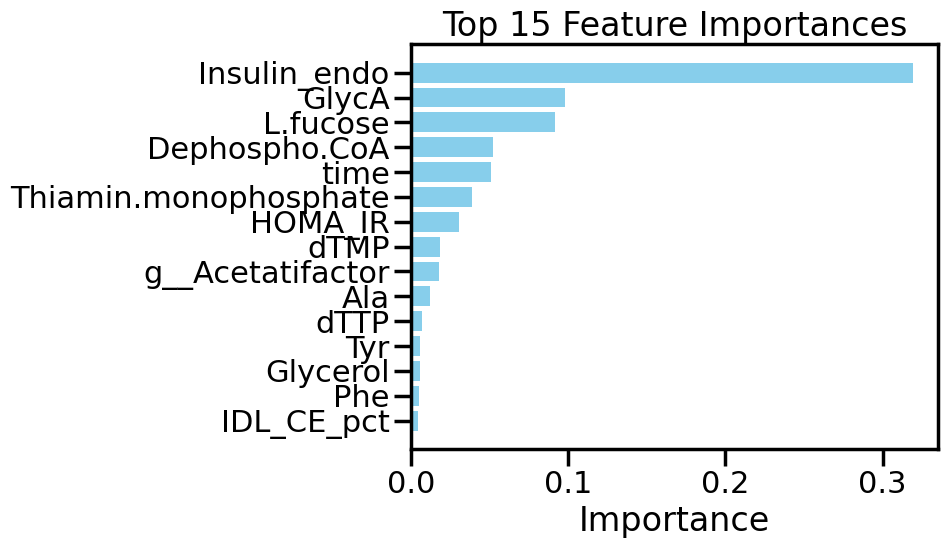

/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:811: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


---------- RUN Prev Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 491.53922145486956 at iteration 1.
INFO     [merf.py:307] Training GLL is 558.0754943361613 at iteration 2.
INFO     [merf.py:307] Training GLL is 546.0518755606637 at iteration 3.
INFO     [merf.py:307] Training GLL is 533.5206720068135 at iteration 4.
INFO     [merf.py:307] Training GLL is 506.34994148597565 at iteration 5.
INFO     [merf.py:307] Training GLL is 485.80766143488336 at iteration 6.
INFO     [merf.py:307] Training GLL is 456.888512867842 at iteration 7.
INFO     [merf.py:307] Training GLL is 446.06184832088695 at iteration 8.
INFO     [merf.py:307] Training GLL is 444.98399401503394 at iteration 9.
INFO     [merf.py:307] Training GLL is 438.94042975173835 at iteration 10.


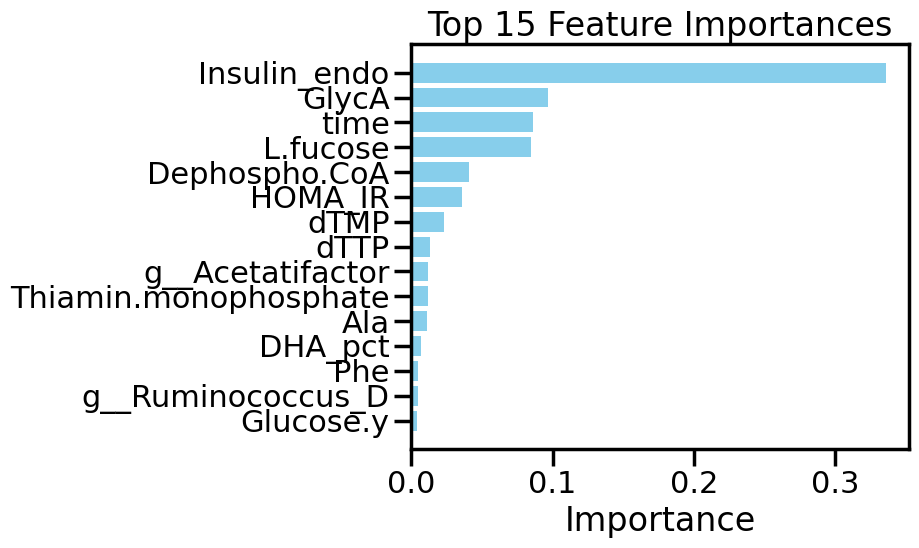

---------- RUN PTEV Model WITH TUNING PARAMETERS 🌱 ----------


/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 654.2103356409682 at iteration 1.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/researchVenv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
INFO     [merf.py:307] Training GLL is 637.5113883087395 at iteration 2.
/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/em_utils.py:795: UserWarning: Tight layout not applied. The left and right margins cannot be made large

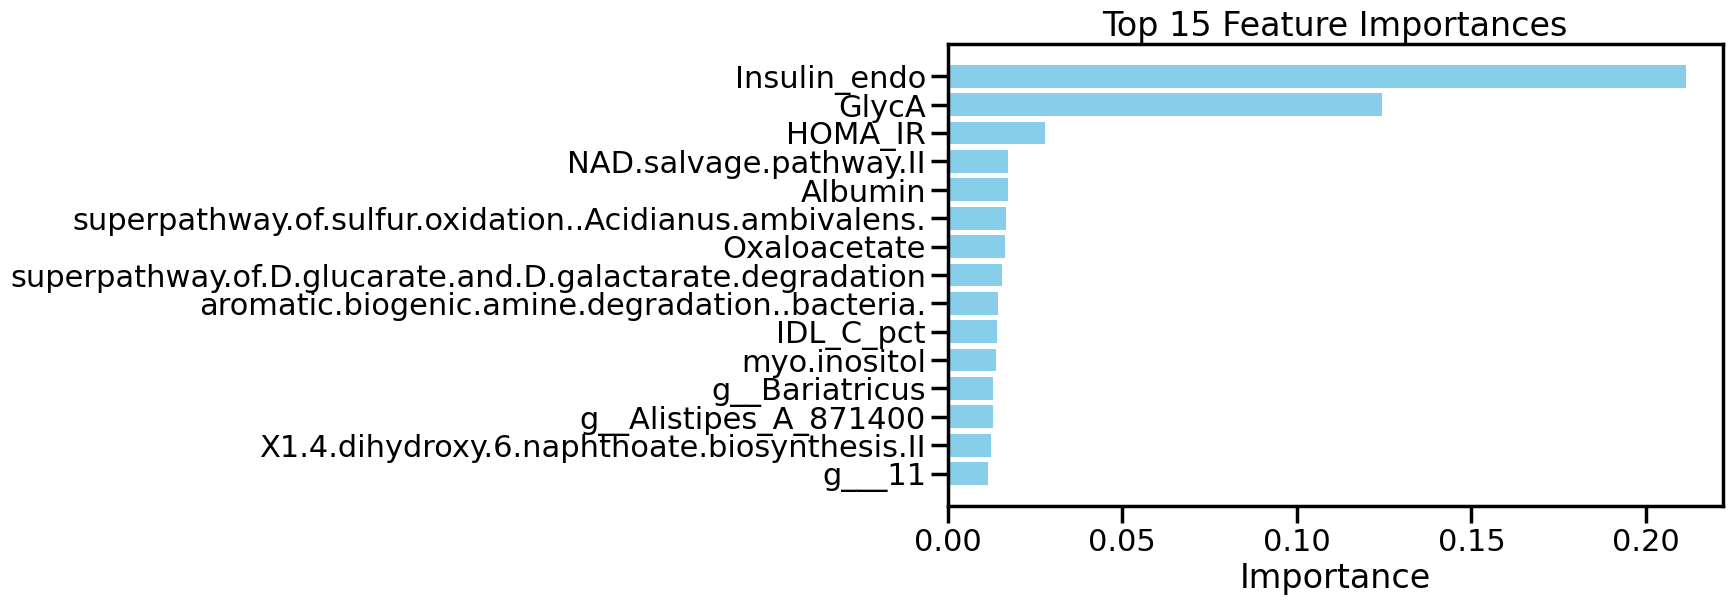

---------- RUN OOB Model WITH TUNING PARAMETERS 🌱 ----------


INFO     [merf.py:307] Training GLL is 668.9948034264575 at iteration 1.
INFO     [merf.py:307] Training GLL is 723.2419939885783 at iteration 2.
INFO     [merf.py:307] Training GLL is 711.873628039855 at iteration 3.
INFO     [merf.py:307] Training GLL is 685.9271597080719 at iteration 4.
INFO     [merf.py:307] Training GLL is 653.0519036178617 at iteration 5.
INFO     [merf.py:307] Training GLL is 615.602537221369 at iteration 6.
INFO     [merf.py:307] Training GLL is 599.761273533323 at iteration 7.
INFO     [merf.py:307] Training GLL is 588.5746818533656 at iteration 8.
INFO     [merf.py:307] Training GLL is 587.5441406760946 at iteration 9.
INFO     [merf.py:307] Training GLL is 587.8036894528022 at iteration 10.


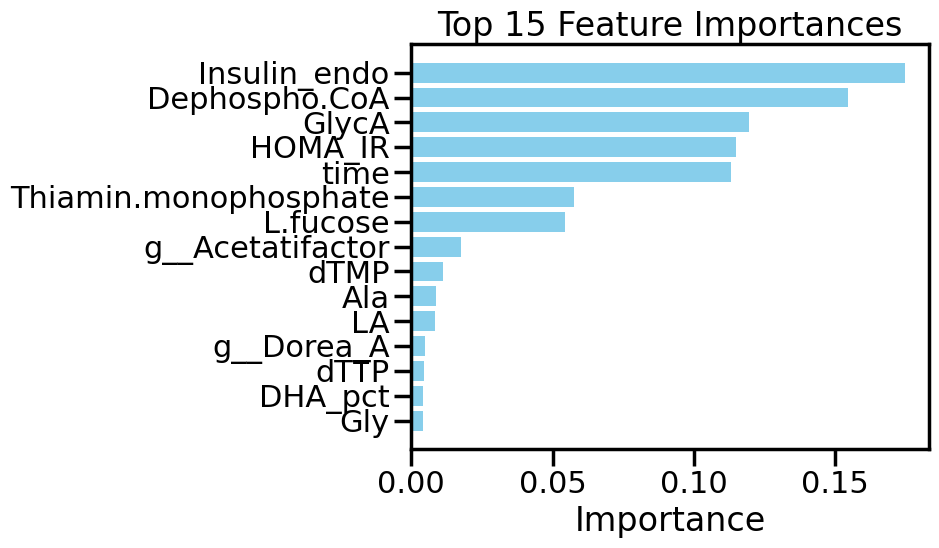

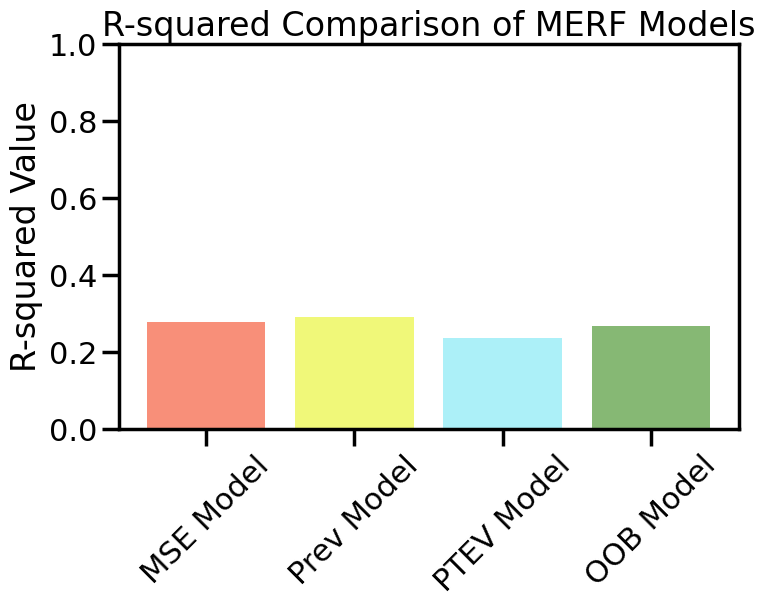

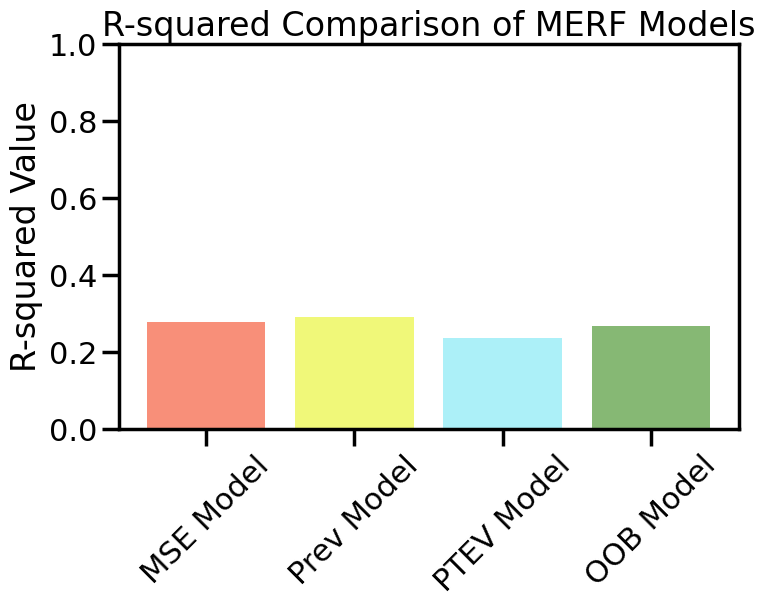

Best model: Prev Model with R-squared: 0.2920


ValueError: not enough values to unpack (expected 3, got 2)

In [15]:
column_sets = {
    #"basic": basic,
    #"meta_keep": meta_keep,
    #"only_grs": only_grs,
    #"only_taxa": only_taxa,
    #"only_micom": only_micom,
    #"only_pathway": only_pathway,
    #"only_metabo" : only_metabo,
    "only_all" : all_col
}
# Loop through each column set and create DATA
for key, columns in column_sets.items():
    DATA = long[columns]
    print(f"Subset for {key} created with shape: {DATA.shape}")
    OUT = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/{key}_long.csv"
    output_dir = "/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/"
    r2_out =  f"{key}_long_r2.pdf"
    r2_adj_out = f"{key}_long_r2_adj.pdf"
    feature_imp_out = f"{key}_long_ft_imp.pdf"
    results_filename = f"/Users/emily/projects/research/Stanislawski/comps/mutli-omic-predictions/play_scripts/2.models/merf_python/may_basic_plus/long/{key}_long.csv"

    # Create train and test sets for the current subset
    train_set = DATA[DATA[ID_VAR].isin(train_names)]  # Select rows where ID_VAR is in train_names
    test_set = DATA[DATA[ID_VAR].isin(test_names)]    # Select rows where ID_VAR is in test_names

    # Ensure clusters_train and clusters_test are pandas Series
    clusters_train = pd.Series(train_set[ID_VAR])  # Convert to pandas Series
    clusters_test = pd.Series(test_set[ID_VAR])    # Convert to pandas Series

    # Proceed with MERF analysis for the current subset
    print(f"---------- Select predictors for training set {key} ----------")
    X = train_set.drop([BMI_VAR, ID_VAR], axis=1)
    Y = train_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
    Z = np.ones((train_set.shape[0], 1))  # Create random effects matrix with ones

    # Check lengths before fitting
    print(f"Length of X: {len(X)}, Length of clusters_train: {len(clusters_train)}, Length of Y: {len(Y)}")
    assert len(X) == len(clusters_train), "Length of X does not match length of clusters_train"
    assert len(X) == len(Y), "Length of X does not match length of Y"
    print("Final columns after drop:", X.columns.to_list())
    print("X train values:", train_set[BMI_VAR])

    print("---------- Select predictors for test set ----------")
    X_new = test_set.drop([BMI_VAR, ID_VAR], axis=1)
    X_new = X_new[X.columns]  # Reorder and select columns to match training set
    X_new = X_new.astype(X.dtypes)  # Ensure data types match
    Y_new = test_set[BMI_VAR].to_numpy()  # Convert Y to numeric array
    clusters_new = pd.Series(test_set[ID_VAR])  # Convert to pandas Series
    Z_new = np.ones((len(X_new), 1))  # Create random effects matrix with ones
    time_new = test_set[TIME_VAR].astype(float).to_numpy()  # Convert time values to numeric arrayo numeric array

    # Hyperparameters to tune
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None],
        'min_samples_split': [0.05, 0.1, 0.15],
        'max_iter': [2, 10],
        'n_splits': [3, 5, 10] #cross-validation
    }
    # Create training features
    # X = train_set.drop(columns=columns_to_drop, errors='ignore')
    y = train_set[[BMI_VAR]]
    y = y[BMI_VAR].to_numpy() # Convert Y to numeric array
    clusters = train_set[ID_VAR].to_numpy() # Get ID variables
    z = np.ones((train_set.shape[0], 1)) # Create random effects matrix with ones

    best_score = float('inf')
    best_params = {}
    results = []  # Initialize a list to store the results of each iteration

    # Loop through all possible combinations of parameters
    total_combinations = len(list(itertools.product(*param_grid.values())))  # Calculate total combinations
    for idx, params in enumerate(itertools.product(*param_grid.values())):
        n_estimators, max_depth, min_samples_split, max_iter, n_splits = params
        
        # Print progress
        progress_percentage = (idx + 1) / total_combinations * 100
        print(f"Combination: {params}\n")
        print(f"Progress: {progress_percentage:.2f}% completed\n")
        scores, prev, ptev, oob_scores = [], [], [], []  # Initialize lists for scores

        # K-fold cross-validation with variable n_splits
        kf = KFold(n_splits=n_splits)
        for train_index, test_index in kf.split(X):
            #print("Train indices:", train_index)
            #print("Test indices:", test_index)
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use .iloc for row selection
            y_train, y_test = y[train_index], y[test_index]
            clusters_train, clusters_test = clusters[train_index], pd.Series(clusters[test_index])
            z_train, z_test = z[train_index], z[test_index]

            print("Length of clusters_train:", len(clusters_train))
            print("Length of clusters_test:", len(clusters_test))
            #print("Train indices:", train_index)
            #print("Test indices:", test_index)

            model = MERF(
                    # Specify the fixed effects model as a Random Forest Regressor
                fixed_effects_model=RandomForestRegressor(
                    n_estimators=n_estimators,  # Number of trees in the forest
                    max_depth=max_depth,  # Maximum depth of each tree
                    min_samples_split=min_samples_split,  # Minimum samples required to split an internal node
                    n_jobs=1,  # Number of jobs to run in parallel
                    oob_score=True  # Whether to use out-of-bag samples to estimate the R^2 on unseen data
                    ),
                    # Generalized Linear Model (GLM) early stopping threshold
                gll_early_stop_threshold=None,  # No early stopping threshold set
                    # Maximum number of iterations for the MERF algorithm
                max_iterations=max_iter  # Maximum number of iterations to run the MERF algorithm
                )
            model.fit(X_train.select_dtypes(include=[np.number]), z_train, pd.Series(clusters_train), y_train)
            y_pred = model.predict(X_test, z_test, clusters_test)
            scores.append(np.mean((y_pred - y_test) ** 2)) # MSE
            
            # Calculate ptev and prev
            total_variance = np.var(y_test)
            random_effect_variance = np.var(y_test - y_pred)
            fixed_effect_variance = total_variance - random_effect_variance

            ptev.append(np.mean(fixed_effect_variance / total_variance if total_variance > 0 else 0))
            prev.append(np.mean(random_effect_variance / total_variance if total_variance > 0 else 0))

            # Calculate OOB score
            forest = model.trained_fe_model
            oob_score = round(forest.oob_score_ * 100, 1)  # percent variation
            oob_scores.append(oob_score)

            # Print ptev, prev, and OOB score for the current iteration
            print(f"Combination, ptev: {np.mean(ptev):.4f}, prev: {np.mean(prev):.4f}, OOB Score: {oob_score:.4f}")

        # Calculate the mean of the scores for the current combination of parameters
        mean_score = np.mean(scores)
        if mean_score < best_score:
            best_score = mean_score
            best_params = params

        # Append the results of the current iteration to the results list
        result_dict = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'max_iter': max_iter,
            'n_splits': n_splits,
            'mean_mse_score': mean_score,
            'mean_prev': np.mean(prev),
            'mean_ptev': np.mean(ptev),
            'oob_score': np.mean(oob_scores)
        }
        results.append(result_dict)

    print("Best parameters:", best_params)
    print("Best score:", best_score)

    # Convert the results list to a DataFrame and save it to a CSV file
    results_df = pd.DataFrame(results)
    results_df.to_csv(OUT, index=False)

    print("---------- Run MERF models ----------")
    r2_values, results_df, feature_imp_out = run_merf_analysis2(
        X, Y, Z, clusters,
        X_new, Y_new, Z_new, clusters_new,
        results_df,
        output_dir, r2_out, r2_adj_out, feature_imp_out, results_filename, time_new)

    # Print the R-squared values and the results DataFrame
    print("R-squared values:", r2_values)
    print("Results DataFrame:\n", results_df)
    print("---------- Done saving Merf output ----------")